In [0]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns

import os
import utils
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
import multiprocessing
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [0]:
import data, model, interpretation, utils, vis_utils, glm

In [0]:
test_data = np.load("test_data.npy")
test_label = np.load("test_label.npy")

test_data = np.reshape(test_data, (251, 1, 64, 64, 64))

# Initialize pretrained model

In [0]:
net = model.SingleTimestep3DCNN(in_num_ch=1, img_size=(64,64,64), inter_num_ch=16, fc_num_ch=16,
                                conv_act='relu', fc_act='tanh').to(torch.device('cpu'))

In [0]:
net.load_state_dict(torch.load('../ckpt/2020_5_18_16_42/epoch031.pth.tar')['model'])

<All keys matched successfully>

In [0]:
net.eval();

In [0]:
brain_map = vis_utils.load_nifti('aal.nii.gz')
brain_areas = np.unique(brain_map)[1:]  # omit background

area_masks = []
for area in tqdm_notebook(brain_areas):
    area_mask = np.zeros_like(brain_map)
    area_mask[brain_map == area] = 1
    area_mask = vis_utils.resize_image(area_mask, (64, 64, 64), interpolation=0)
    area_masks.append(area_mask)

area_names = ['Precentral_L', 'Precentral_R', 'Frontal_Sup_L', 'Frontal_Sup_R', 'Frontal_Sup_Orb_L', 'Frontal_Sup_Orb_R', 'Frontal_Mid_L', 'Frontal_Mid_R', 'Frontal_Mid_Orb_L', 'Frontal_Mid_Orb_R', 'Frontal_Inf_Oper_L', 'Frontal_Inf_Oper_R', 'Frontal_Inf_Tri_L', 'Frontal_Inf_Tri_R', 'Frontal_Inf_Orb_L', 'Frontal_Inf_Orb_R', 'Rolandic_Oper_L', 'Rolandic_Oper_R', 'Supp_Motor_Area_L', 'Supp_Motor_Area_R', 'Olfactory_L', 'Olfactory_R', 'Frontal_Sup_Medial_L', 'Frontal_Sup_Medial_R', 'Frontal_Med_Orb_L', 'Frontal_Med_Orb_R', 'Rectus_L', 'Rectus_R', 'Insula_L', 'Insula_R', 'Cingulum_Ant_L', 'Cingulum_Ant_R', 'Cingulum_Mid_L', 'Cingulum_Mid_R', 'Cingulum_Post_L', 'Cingulum_Post_R', 'Hippocampus_L', 'Hippocampus_R', 'ParaHippocampal_L', 'ParaHippocampal_R', 'Amygdala_L', 'Amygdala_R', 'Calcarine_L', 'Calcarine_R', 'Cuneus_L', 'Cuneus_R', 'Lingual_L', 'Lingual_R', 'Occipital_Sup_L', 'Occipital_Sup_R', 'Occipital_Mid_L', 'Occipital_Mid_R', 'Occipital_Inf_L', 'Occipital_Inf_R', 'Fusiform_L', 'Fusiform_R', 'Postcentral_L', 'Postcentral_R', 'Parietal_Sup_L', 'Parietal_Sup_R', 'Parietal_Inf_L', 'Parietal_Inf_R', 'SupraMarginal_L', 'SupraMarginal_R', 'Angular_L', 'Angular_R', 'Precuneus_L', 'Precuneus_R', 'Paracentral_Lobule_L', 'Paracentral_Lobule_R', 'Caudate_L', 'Caudate_R', 'Putamen_L', 'Putamen_R', 'Pallidum_L', 'Pallidum_R', 'Thalamus_L', 'Thalamus_R', 'Heschl_L', 'Heschl_R', 'Temporal_Sup_L', 'Temporal_Sup_R', 'Temporal_Pole_Sup_L', 'Temporal_Pole_Sup_R', 'Temporal_Mid_L', 'Temporal_Mid_R', 'Temporal_Pole_Mid_L', 'Temporal_Pole_Mid_R', 'Temporal_Inf_L', 'Temporal_Inf_R', 'Cerebelum_Crus1_L', 'Cerebelum_Crus1_R', 'Cerebelum_Crus2_L', 'Cerebelum_Crus2_R', 'Cerebelum_3_L', 'Cerebelum_3_R', 'Cerebelum_4_5_L', 'Cerebelum_4_5_R', 'Cerebelum_6_L', 'Cerebelum_6_R', 'Cerebelum_7b_L', 'Cerebelum_7b_R', 'Cerebelum_8_L', 'Cerebelum_8_R', 'Cerebelum_9_L', 'Cerebelum_9_R', 'Cerebelum_10_L', 'Cerebelum_10_R', 'Vermis_1_2', 'Vermis_3', 'Vermis_4_5', 'Vermis_6', 'Vermis_7', 'Vermis_8', 'Vermis_9', 'Vermis_10']

# Merge left and right areas.
merged_area_names = [name[:-2] for name in area_names[:108:2]] + area_names[108:]

In [0]:
def get_relevance_per_area(relevance_map, normalize=True):
    relevances = np.zeros(len(area_masks))
    print(relevances.shape)
    for i, area_mask in enumerate(area_masks):
        relevances[i] = np.sum(relevance_map * area_mask)
    if normalize:
        relevances /= relevances.sum()  # make all areas sum to 1

    # Merge left and right areas.
    merged_relevances = np.concatenate([relevances[:108].reshape(-1, 2).sum(1), relevances[108:]])

    return sorted(zip(merged_area_names, merged_relevances), key=lambda x: x[1], reverse=True)

In [0]:
brain_map.shape

(181, 217, 181)

# Sensitivity Analysis

- Loop through all test examples. 
- For each, record whether its label is NC or AD
- get relevance_map_backprop, and record whether it was correctly classified or not
- average relevance_map_backprop[0] at the end across the 4 categories (correct vs wrong classification, NC vs AD label)
- build dict, add up percentages of top 10 (for efficiency) areas -> then take top 5


In [0]:
#dict_A = {'a': 10, 'b': 5.4}
#dict_B = {'b': 1, 'c': 2}
#test_merge = merge_dicts(dict_A, dict_B)
#print(test_merge)

In [0]:
# shape: (1, 64, 64, 64)
# relevance maps; to be averaged after summing
map_AD_correct = np.zeros((1, 64, 64, 64))
map_AD_wrong = np.zeros((1, 64, 64, 64))
map_NC_correct = np.zeros((1, 64, 64, 64))
map_NC_wrong = np.zeros((1, 64, 64, 64))
map_AD = np.zeros((1, 64, 64, 64))
map_NC = np.zeros((1, 64, 64, 64))

# counts... to keep track and average later
count_AD_correct = 0
count_AD_wrong = 0
count_NC_correct = 0
count_NC_wrong = 0
count_AD = 0
count_NC = 0

# average of test images
img_AD_correct = np.zeros((64, 64, 64))
img_AD_wrong = np.zeros((64, 64, 64))
img_NC_correct = np.zeros((64, 64, 64))
img_NC_wrong = np.zeros((64, 64, 64))
img_AD = np.zeros((64, 64, 64))
img_NC = np.zeros((64, 64, 64))
img_global = np.zeros((64, 64, 64)) # average of entire dataset

# dict of top brain areas; to be summed
dict_AD_correct = {}
dict_AD_wrong = {}
dict_NC_correct = {}
dict_NC_wrong = {}
dict_AD = {}
dict_NC = {}

for i in range(251):
  #if i % 20 == 0:
  print("i: ", i)
  label = test_label[i]
  relevance_map_backprop, pred_label, _ = interpretation.sensitivity_analysis(net, test_data[i], cuda=False, verbose=True)
  case = -1
  if label == 1 and pred_label == 1:
    case = 1
    count_AD_correct += 1
    img_AD_correct += test_data[i][0]
    map_AD_correct += relevance_map_backprop
  elif label == 1 and pred_label == 0:
    case = 2
    count_AD_wrong += 1
    img_AD_wrong += test_data[i][0]
    map_AD_wrong += relevance_map_backprop
  elif label == 0 and pred_label == 0:
    case = 3
    count_NC_correct += 1
    img_NC_correct += test_data[i][0]
    map_NC_correct += relevance_map_backprop
  elif label == 0 and pred_label == 1:
    case = 4
    count_NC_wrong += 1
    img_NC_wrong += test_data[i][0]
    map_NC_wrong += relevance_map_backprop
  else:
    print("entered invalid case with (label, pred_label) = ", label, pred_label)
  
  areas_top_ten = get_relevance_per_area(relevance_map_backprop[0])[:10]
  dict_example = None
  if case == 1:
    dict_example = dict_AD_correct
  elif case == 2:
    dict_example = dict_AD_wrong
  elif case == 3:
    dict_example = dict_NC_correct
  elif case == 4:
    dict_example = dict_NC_wrong
  else: 
    print("invalid case ", case)
  for (area, pct) in areas_top_ten:
    if area in dict_example:
      dict_example[area] += pct
    else:
      dict_example[area] = pct



i:  0
tensor([[-6.2830]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9981356577482074
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  1
tensor([[-5.2428]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.994742373470217
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  2
tensor([[-5.6378]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9964518633205444
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  3
tensor([[5.5752]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 1 with probability 0.9962234497070312
one hot output:  tensor([[[0.],
         [1.]]])
(116,)
i:  4
tensor([[6.3118]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 1 with probability 0.9981884360313416
one hot output:  tensor([[[0.],
         [1.]]])
(116,)
i:  5
tensor([[6.1840]], grad_fn=<AddmmBackward>) torch.Size([1

one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  44
tensor([[-6.2622]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9980966681614518
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  45
tensor([[-6.3881]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9983213740633801
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  46
tensor([[-6.3722]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9982945543015376
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  47
tensor([[-6.3560]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9982667082222179
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  48
tensor([[-6.3329]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9982263350393623
one hot output:  tensor([[[1.],
         [0.]]])
(116,)

(116,)
i:  88
tensor([[5.4006]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 1 with probability 0.9955064058303833
one hot output:  tensor([[[0.],
         [1.]]])
(116,)
i:  89
tensor([[5.8918]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 1 with probability 0.9972456693649292
one hot output:  tensor([[[0.],
         [1.]]])
(116,)
i:  90
tensor([[2.7935]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 1 with probability 0.942322850227356
one hot output:  tensor([[[0.],
         [1.]]])
(116,)
i:  91
tensor([[1.7586]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 1 with probability 0.8530322313308716
one hot output:  tensor([[[0.],
         [1.]]])
(116,)
i:  92
tensor([[2.4333]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 1 with probability 0.9193318486213684
one hot output:  tensor([[[0.],
         [1.]]])
(116,)
i:  93
tensor([[5.3471]], grad_fn=<AddmmBackward>) tor

(116,)
i:  132
tensor([[-6.3775]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9983035598415881
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  133
tensor([[3.3467]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 1 with probability 0.9659955501556396
one hot output:  tensor([[[0.],
         [1.]]])
(116,)
i:  134
tensor([[5.8235]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 1 with probability 0.9970515966415405
one hot output:  tensor([[[0.],
         [1.]]])
(116,)
i:  135
tensor([[5.5013]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 1 with probability 0.9959350824356079
one hot output:  tensor([[[0.],
         [1.]]])
(116,)
i:  136
tensor([[5.9569]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 1 with probability 0.9974186420440674
one hot output:  tensor([[[0.],
         [1.]]])
(116,)
i:  137
tensor([[6.0031]], grad_fn=<AddmmBackwa

(116,)
i:  176
tensor([[-6.0088]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9975489396601915
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  177
tensor([[-3.7568]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9771744720637798
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  178
tensor([[-6.3187]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9982010213425383
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  179
tensor([[-0.9474]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.7205913662910461
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  180
tensor([[3.1591]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 1 with probability 0.9592643976211548
one hot output:  tensor([[[0.],
         [1.]]])
(116,)
i:  181
tensor([[5.1106]], grad_fn=<AddmmBac

(116,)
i:  220
tensor([[6.0819]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 1 with probability 0.9977214932441711
one hot output:  tensor([[[0.],
         [1.]]])
(116,)
i:  221
tensor([[-6.3781]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9983045931439847
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  222
tensor([[-6.2252]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.998024944216013
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  223
tensor([[6.0012]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 1 with probability 0.9975302815437317
one hot output:  tensor([[[0.],
         [1.]]])
(116,)
i:  224
tensor([[-1.0887]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.7481370866298676
one hot output:  tensor([[[1.],
         [0.]]])
(116,)
i:  225
tensor([[-6.3121]], grad_fn=<AddmmBack

In [0]:
# some post-processing
map_AD = map_AD_correct + map_AD_wrong
map_NC = map_NC_correct + map_NC_wrong
count_AD = count_AD_correct + count_AD_wrong
count_NC = count_NC_correct + count_NC_wrong
img_AD = img_AD_correct + img_AD_wrong 
img_NC = img_NC_correct + img_NC_wrong
img_global = img_AD + img_NC

dict_AD = data.merge_dicts(dict_AD_correct, dict_AD_wrong)
dict_NC = data.merge_dicts(dict_NC_correct, dict_NC_wrong)

In [0]:
print(count_AD_correct, count_AD_wrong, count_NC_correct, count_NC_wrong)

57 32 149 13


In [0]:
# we need to average the maps across the number of examples that were summed up
map_AD_correct /= count_AD_correct
map_AD_wrong /= count_AD_wrong
map_NC_correct /= count_NC_correct
map_NC_wrong /= count_NC_wrong
map_AD /= count_AD
map_NC /= count_NC

# also average the images
img_AD_correct /= count_AD_correct
img_AD_wrong /= count_AD_wrong
img_NC_correct /= count_NC_correct
img_NC_wrong /= count_NC_wrong
img_AD /= count_AD
img_NC /= count_NC
img_global /= 251

-0.7620625321536576 1.9976536631661175 2.4692311611575374e-07 0.003333959016368086
-0.7620625321536576 1.9976536631661175 2.1960833990371242e-07 0.006435240801810465
-0.7620625321536576 1.9976536631661175 6.409916602041302e-08 0.001898909069749164
-0.7620625321536576 1.9976536631661175 2.3722645454864295e-07 0.009933414743653194
-0.7620625321536576 1.9976536631661175 3.0224290583341143e-07 0.003991627657199115
-0.7620625321536576 1.9976536631661175 8.416797555004248e-08 0.002378225567695678


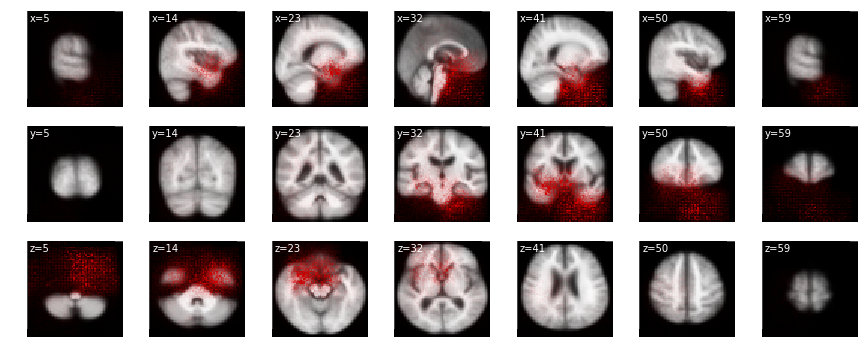

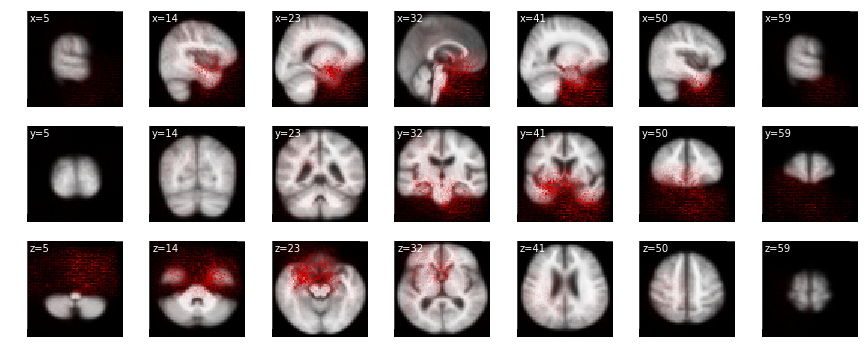

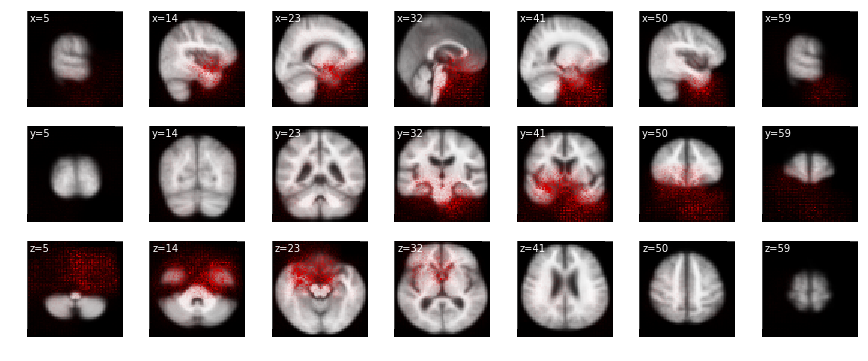

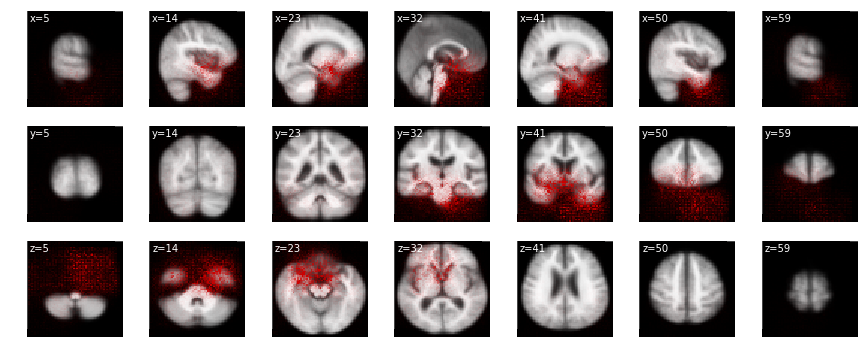

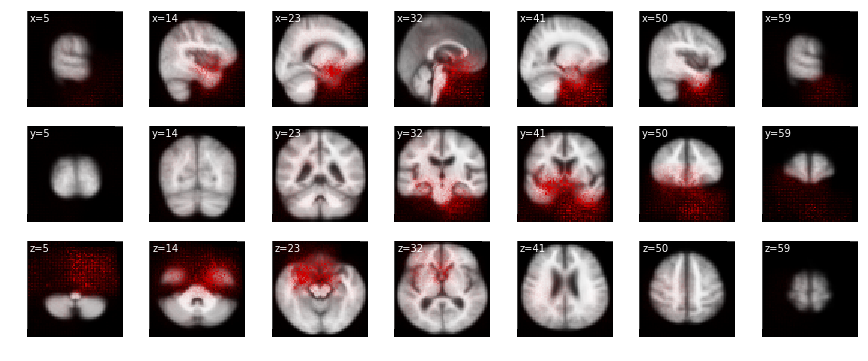

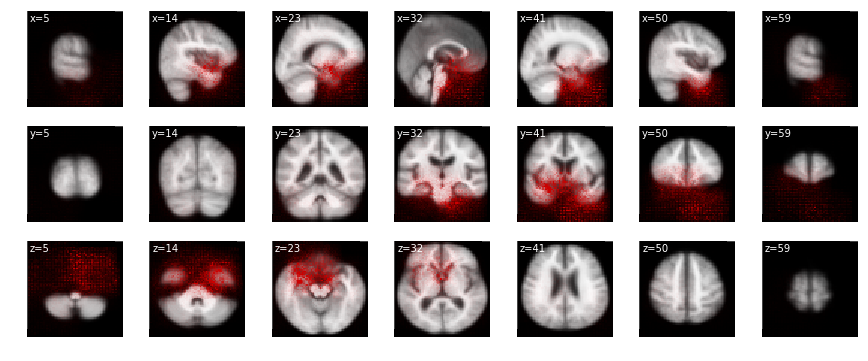

In [0]:
# now we plot the averaged maps, for each category!
# probably want to do some quantitative results with the vmin, vmax, overlay min/max
vmin_AD_correct, vmax_AD_correct, overlay_vmin_AD_correct, overlay_vmax_AD_correct = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_AD_correct[0], 
                  overlay_vmax=np.percentile(map_AD_correct, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_AD_wrong, vmax_AD_wrong, overlay_vmin_AD_wrong, overlay_vmax_AD_wrong = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_AD_wrong[0], 
                  overlay_vmax=np.percentile(map_AD_wrong, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_NC_correct, vmax_NC_correct, overlay_vmin_NC_correct, overlay_vmax_NC_correct = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_NC_correct[0], 
                  overlay_vmax=np.percentile(map_NC_correct, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_NC_wrong, vmax_NC_wrong, overlay_vmin_NC_wrong, overlay_vmax_NC_wrong = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_NC_wrong[0], 
                  overlay_vmax=np.percentile(map_NC_wrong, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_AD, vmax_AD, overlay_vmin_AD, overlay_vmax_AD = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_AD[0], 
                  overlay_vmax=np.percentile(map_AD, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_NC, vmax_NC, overlay_vmin_NC, overlay_vmax_NC = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_NC[0], 
                  overlay_vmax=np.percentile(map_NC, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)


In [0]:
# get relevance areas across each category
from operator import itemgetter

res_AD_correct = dict(sorted(dict_AD_correct.items(), key = itemgetter(1), reverse = True)[:5])
res_AD_wrong = dict(sorted(dict_AD_wrong.items(), key = itemgetter(1), reverse = True)[:5])
res_NC_correct = dict(sorted(dict_NC_correct.items(), key = itemgetter(1), reverse = True)[:5])
res_NC_wrong = dict(sorted(dict_NC_wrong.items(), key = itemgetter(1), reverse = True)[:5])
res_AD = dict(sorted(dict_AD.items(), key = itemgetter(1), reverse = True)[:5])
res_NC = dict(sorted(dict_NC.items(), key = itemgetter(1), reverse = True)[:5])

print(res_AD_correct)
print(res_AD_wrong)
print(res_NC_correct)
print(res_NC_wrong)
print(res_AD)
print(res_NC)


{'Temporal_Inf': 4.254390526536008, 'Frontal_Inf_Orb': 3.3366467560405795, 'Temporal_Mid': 2.7627877799797673, 'Temporal_Pole_Mid': 2.6341470253110164, 'Insula': 2.5566078734039115}
{'Temporal_Inf': 2.0128953899864386, 'Frontal_Inf_Orb': 1.7858318370508421, 'Insula': 1.5794147199537805, 'Temporal_Mid': 1.3858291071631743, 'Putamen': 1.2201160277864644}
{'Temporal_Inf': 8.888651354956417, 'Frontal_Inf_Orb': 7.846986335416999, 'Insula': 7.416941950331142, 'Temporal_Mid': 6.743456727764159, 'Frontal_Inf_Tri': 5.72849355992265}
{'Temporal_Inf': 0.9111956899747429, 'Frontal_Inf_Orb': 0.7745159513202629, 'Insula': 0.664944610366657, 'Temporal_Mid': 0.6343623733414433, 'Temporal_Pole_Sup': 0.564293514290062}
{'Temporal_Inf': 6.267285916522447, 'Frontal_Inf_Orb': 5.122478593091421, 'Temporal_Mid': 4.148616887142942, 'Insula': 4.136022593357692, 'Temporal_Pole_Mid': 3.634616750470233}
{'Temporal_Inf': 9.79984704493116, 'Frontal_Inf_Orb': 8.621502286737263, 'Insula': 8.0818865606978, 'Temporal_M

# Guided backprop

In [0]:
# shape: (1, 64, 64, 64)
# relevance maps; to be averaged after summing
map_AD_correct = np.zeros((1, 64, 64, 64))
map_AD_wrong = np.zeros((1, 64, 64, 64))
map_NC_correct = np.zeros((1, 64, 64, 64))
map_NC_wrong = np.zeros((1, 64, 64, 64))
map_AD = np.zeros((1, 64, 64, 64))
map_NC = np.zeros((1, 64, 64, 64))

# counts... to keep track and average later
count_AD_correct = 0
count_AD_wrong = 0
count_NC_correct = 0
count_NC_wrong = 0
count_AD = 0
count_NC = 0

# average of test images
img_AD_correct = np.zeros((64, 64, 64))
img_AD_wrong = np.zeros((64, 64, 64))
img_NC_correct = np.zeros((64, 64, 64))
img_NC_wrong = np.zeros((64, 64, 64))
img_AD = np.zeros((64, 64, 64))
img_NC = np.zeros((64, 64, 64))
img_global = np.zeros((64, 64, 64)) # average of entire dataset

# dict of top brain areas; to be summed
dict_AD_correct = {}
dict_AD_wrong = {}
dict_NC_correct = {}
dict_NC_wrong = {}
dict_AD = {}
dict_NC = {}

for i in range(251):
  #if i % 20 == 0:
  print("i: ", i)
  label = test_label[i]
  relevance_map_backprop, pred_label, _ = interpretation.guided_backprop(net, test_data[i], cuda=False, verbose=True)
  case = -1
  if label == 1 and pred_label == 1:
    case = 1
    count_AD_correct += 1
    img_AD_correct += test_data[i][0]
    map_AD_correct += relevance_map_backprop
  elif label == 1 and pred_label == 0:
    case = 2
    count_AD_wrong += 1
    img_AD_wrong += test_data[i][0]
    map_AD_wrong += relevance_map_backprop
  elif label == 0 and pred_label == 0:
    case = 3
    count_NC_correct += 1
    img_NC_correct += test_data[i][0]
    map_NC_correct += relevance_map_backprop
  elif label == 0 and pred_label == 1:
    case = 4
    count_NC_wrong += 1
    img_NC_wrong += test_data[i][0]
    map_NC_wrong += relevance_map_backprop
  else:
    print("entered invalid case with (label, pred_label) = ", label, pred_label)
  
  areas_top_ten = get_relevance_per_area(relevance_map_backprop[0])[:10]
  dict_example = None
  if case == 1:
    dict_example = dict_AD_correct
  elif case == 2:
    dict_example = dict_AD_wrong
  elif case == 3:
    dict_example = dict_NC_correct
  elif case == 4:
    dict_example = dict_NC_wrong
  else: 
    print("invalid case ", case)
  for (area, pct) in areas_top_ten:
    if area in dict_example:
      dict_example[area] += pct
    else:
      dict_example[area] = pct

i:  0
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
tensor([[-6.2830]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9981356577482074
one hot output:  tensor([[[1.],
         [0.]]])
Removing 4 hook(s)
(116,)
i:  1
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
tensor([[-5.2428]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.994742373470217
one hot output:  tensor([[[1.],
         [0.]]])
Removing 4 hook(s)
(116,)
i:  2
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
tensor([[-5.6378]], grad_fn=<

Removing 4 hook(s)
(116,)
i:  22
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
tensor([[-6.3560]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9982667560689151
one hot output:  tensor([[[1.],
         [0.]]])
Removing 4 hook(s)
(116,)
i:  23
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
tensor([[-6.0995]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9977611280046403
one hot output:  tensor([[[1.],
         [0.]]])
Removing 4 hook(s)
(116,)
i:  24
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)

Removing 4 hook(s)
(116,)
i:  43
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
tensor([[-4.3458]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9872049344703555
one hot output:  tensor([[[1.],
         [0.]]])
Removing 4 hook(s)
(116,)
i:  44
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
tensor([[-6.2622]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9980966681614518
one hot output:  tensor([[[1.],
         [0.]]])
Removing 4 hook(s)
(116,)
i:  45
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)

Removing 4 hook(s)
(116,)
i:  64
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
tensor([[-6.4091]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9983561938861385
one hot output:  tensor([[[1.],
         [0.]]])
Removing 4 hook(s)
(116,)
i:  65
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
tensor([[-6.4077]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.998353835195303
one hot output:  tensor([[[1.],
         [0.]]])
Removing 4 hook(s)
(116,)
i:  66
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)


Removing 4 hook(s)
(116,)
i:  85
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
tensor([[-0.7231]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.6732941269874573
one hot output:  tensor([[[1.],
         [0.]]])
Removing 4 hook(s)
(116,)
i:  86
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
tensor([[-3.5508]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.972098870202899
one hot output:  tensor([[[1.],
         [0.]]])
Removing 4 hook(s)
(116,)
i:  87
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)


Removing 4 hook(s)
(116,)
i:  106
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
tensor([[-6.3114]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9981878164689988
one hot output:  tensor([[[1.],
         [0.]]])
Removing 4 hook(s)
(116,)
i:  107
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
tensor([[6.2110]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 1 with probability 0.9979968667030334
one hot output:  tensor([[[0.],
         [1.]]])
Removing 4 hook(s)
(116,)
i:  108
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=Tru

Removing 4 hook(s)
(116,)
i:  127
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
tensor([[-6.3535]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9982623297255486
one hot output:  tensor([[[1.],
         [0.]]])
Removing 4 hook(s)
(116,)
i:  128
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
tensor([[-6.3180]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9981996739516035
one hot output:  tensor([[[1.],
         [0.]]])
Removing 4 hook(s)
(116,)
i:  129
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=Tr

Removing 4 hook(s)
(116,)
i:  148
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
tensor([[3.0932]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 1 with probability 0.9566100239753723
one hot output:  tensor([[[0.],
         [1.]]])
Removing 4 hook(s)
(116,)
i:  149
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
tensor([[4.6525]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 1 with probability 0.9905520677566528
one hot output:  tensor([[[0.],
         [1.]]])
Removing 4 hook(s)
(116,)
i:  150
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True

Removing 4 hook(s)
(116,)
i:  169
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
tensor([[-6.4037]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9983473242027685
one hot output:  tensor([[[1.],
         [0.]]])
Removing 4 hook(s)
(116,)
i:  170
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
tensor([[-6.3886]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9983221993315965
one hot output:  tensor([[[1.],
         [0.]]])
Removing 4 hook(s)
(116,)
i:  171
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=Tr

Removing 4 hook(s)
(116,)
i:  190
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
tensor([[-4.1535]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.984533129259944
one hot output:  tensor([[[1.],
         [0.]]])
Removing 4 hook(s)
(116,)
i:  191
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
tensor([[-5.9135]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9973046300001442
one hot output:  tensor([[[1.],
         [0.]]])
Removing 4 hook(s)
(116,)
i:  192
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=Tru

Removing 4 hook(s)
(116,)
i:  211
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
tensor([[-5.8678]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9971787719987333
one hot output:  tensor([[[1.],
         [0.]]])
Removing 4 hook(s)
(116,)
i:  212
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
tensor([[-6.3430]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9982439902378246
one hot output:  tensor([[[1.],
         [0.]]])
Removing 4 hook(s)
(116,)
i:  213
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=Tr

Removing 4 hook(s)
(116,)
i:  232
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
tensor([[-5.6564]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.996517060790211
one hot output:  tensor([[[1.],
         [0.]]])
Removing 4 hook(s)
(116,)
i:  233
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
tensor([[-5.8503]], grad_fn=<AddmmBackward>) torch.Size([1, 1])
Image was classified as 0 with probability 0.9971293713897467
one hot output:  tensor([[[1.],
         [0.]]])
Removing 4 hook(s)
(116,)
i:  234
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=True)
Registered hook for layer: ReLU(inplace=Tru

In [0]:
# some post-processing
map_AD = map_AD_correct + map_AD_wrong
map_NC = map_NC_correct + map_NC_wrong
count_AD = count_AD_correct + count_AD_wrong
count_NC = count_NC_correct + count_NC_wrong
img_AD = img_AD_correct + img_AD_wrong 
img_NC = img_NC_correct + img_NC_wrong
img_global = img_AD + img_NC

dict_AD = data.merge_dicts(dict_AD_correct, dict_AD_wrong)
dict_NC = data.merge_dicts(dict_NC_correct, dict_NC_wrong)

In [0]:
print(count_AD_correct, count_AD_wrong, count_NC_correct, count_NC_wrong)

In [0]:
# we need to average the maps across the number of examples that were summed up
map_AD_correct /= count_AD_correct
map_AD_wrong /= count_AD_wrong
map_NC_correct /= count_NC_correct
map_NC_wrong /= count_NC_wrong
map_AD /= count_AD
map_NC /= count_NC

# also average the images
img_AD_correct /= count_AD_correct
img_AD_wrong /= count_AD_wrong
img_NC_correct /= count_NC_correct
img_NC_wrong /= count_NC_wrong
img_AD /= count_AD
img_NC /= count_NC
img_global /= 251

-0.7620625321536576 1.9976536631661175 2.9747660975602755e-09 0.001776868407235964
-0.7620625321536576 1.9976536631661175 8.311000550091652e-09 0.002719915920953763
-0.7620625321536576 1.9976536631661175 3.486766030422465e-09 0.0009605348968436227
-0.7620625321536576 1.9976536631661175 5.526240115089492e-09 0.005267096766605651
-0.7620625321536576 1.9976536631661175 4.893412192852456e-09 0.00209058121773617
-0.7620625321536576 1.9976536631661175 3.650427531043893e-09 0.001272545732196253


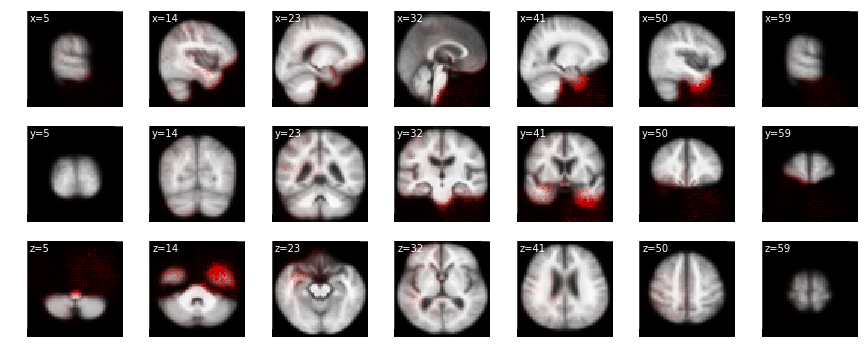

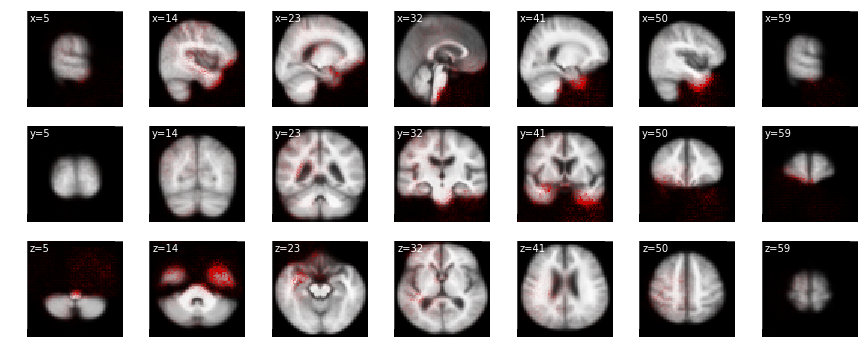

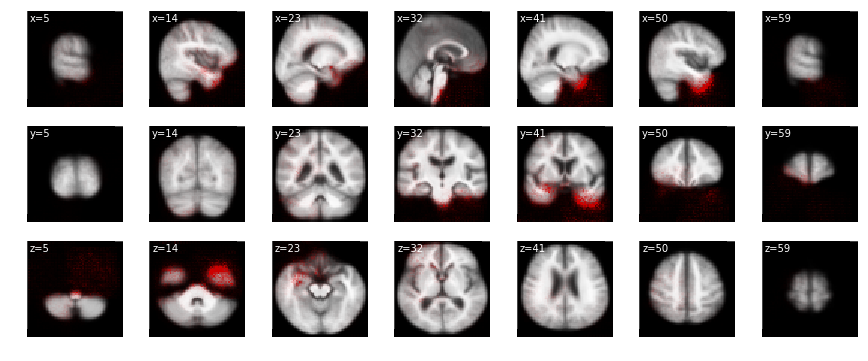

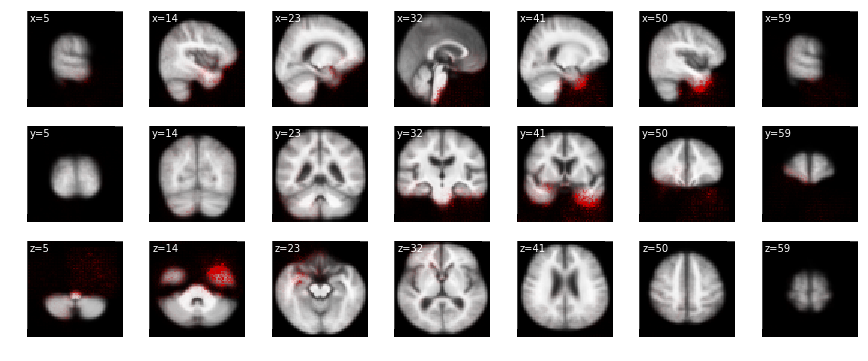

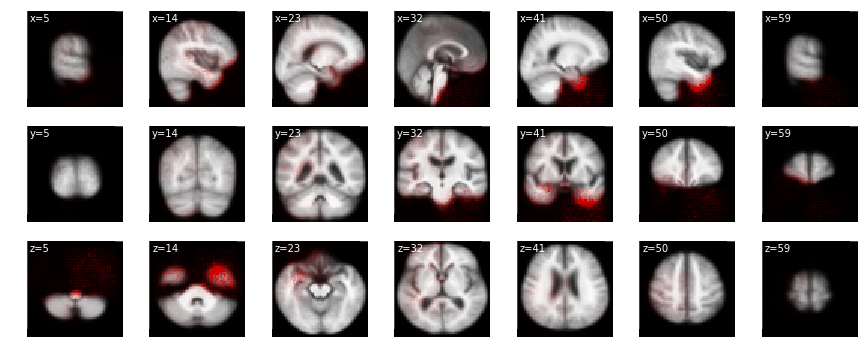

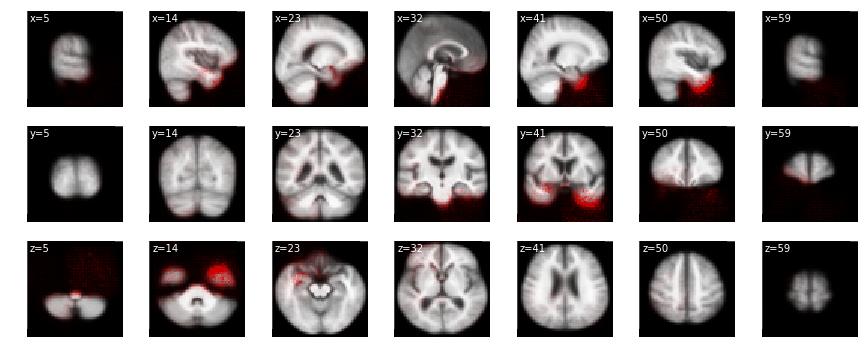

In [0]:
# now we plot the averaged maps, for each category!
# probably want to do some quantitative results with the vmin, vmax, overlay min/max
vmin_AD_correct, vmax_AD_correct, overlay_vmin_AD_correct, overlay_vmax_AD_correct = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_AD_correct[0], 
                  overlay_vmax=np.percentile(map_AD_correct, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_AD_wrong, vmax_AD_wrong, overlay_vmin_AD_wrong, overlay_vmax_AD_wrong = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_AD_wrong[0], 
                  overlay_vmax=np.percentile(map_AD_wrong, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_NC_correct, vmax_NC_correct, overlay_vmin_NC_correct, overlay_vmax_NC_correct = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_NC_correct[0], 
                  overlay_vmax=np.percentile(map_NC_correct, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_NC_wrong, vmax_NC_wrong, overlay_vmin_NC_wrong, overlay_vmax_NC_wrong = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_NC_wrong[0], 
                  overlay_vmax=np.percentile(map_NC_wrong, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_AD, vmax_AD, overlay_vmin_AD, overlay_vmax_AD = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_AD[0], 
                  overlay_vmax=np.percentile(map_AD, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_NC, vmax_NC, overlay_vmin_NC, overlay_vmax_NC = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_NC[0], 
                  overlay_vmax=np.percentile(map_NC, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

In [0]:
# get relevance areas across each category
from operator import itemgetter

res_AD_correct = dict(sorted(dict_AD_correct.items(), key = itemgetter(1), reverse = True)[:5])
res_AD_wrong = dict(sorted(dict_AD_wrong.items(), key = itemgetter(1), reverse = True)[:5])
res_NC_correct = dict(sorted(dict_NC_correct.items(), key = itemgetter(1), reverse = True)[:5])
res_NC_wrong = dict(sorted(dict_NC_wrong.items(), key = itemgetter(1), reverse = True)[:5])
res_AD = dict(sorted(dict_AD.items(), key = itemgetter(1), reverse = True)[:5])
res_NC = dict(sorted(dict_NC.items(), key = itemgetter(1), reverse = True)[:5])

print(res_AD_correct)
print(res_AD_wrong)
print(res_NC_correct)
print(res_NC_wrong)
print(res_AD)
print(res_NC)

{'Temporal_Inf': 5.587689287562929, 'Temporal_Pole_Mid': 4.924554203292608, 'Frontal_Inf_Orb': 4.843317684709106, 'Temporal_Pole_Sup': 4.052955150463409, 'Temporal_Mid': 3.2138895576492548}
{'Temporal_Inf': 2.7498169044216687, 'Frontal_Inf_Orb': 2.541423769917496, 'Temporal_Pole_Mid': 2.306481451222604, 'Temporal_Pole_Sup': 1.6242020209636672, 'Temporal_Mid': 1.5147452508827823}
{'Temporal_Inf': 11.01596217442301, 'Frontal_Inf_Orb': 8.380277070611585, 'Temporal_Mid': 7.0493246976854405, 'Temporal_Pole_Mid': 6.690716692405093, 'Temporal_Pole_Sup': 4.435792641638532}
{'Temporal_Inf': 1.3054731472163597, 'Temporal_Pole_Mid': 1.2457360859002051, 'Frontal_Inf_Orb': 1.199191500328773, 'Temporal_Pole_Sup': 0.9298218443304942, 'Temporal_Mid': 0.7169916240029387}
{'Temporal_Inf': 8.337506191984598, 'Frontal_Inf_Orb': 7.384741454626602, 'Temporal_Pole_Mid': 7.231035654515212, 'Temporal_Pole_Sup': 5.677157171427076, 'Temporal_Mid': 4.728634808532037}
{'Temporal_Inf': 12.321435321639369, 'Frontal_

# Occlusion



In [0]:
# shape: (1, 64, 64, 64)
# relevance maps; to be averaged after summing
map_AD_correct = np.zeros((1, 64, 64, 64))
map_AD_wrong = np.zeros((1, 64, 64, 64))
map_NC_correct = np.zeros((1, 64, 64, 64))
map_NC_wrong = np.zeros((1, 64, 64, 64))
map_AD = np.zeros((1, 64, 64, 64))
map_NC = np.zeros((1, 64, 64, 64))

# counts... to keep track and average later
count_AD_correct = 0
count_AD_wrong = 0
count_NC_correct = 0
count_NC_wrong = 0
count_AD = 0
count_NC = 0

# average of test images
img_AD_correct = np.zeros((64, 64, 64))
img_AD_wrong = np.zeros((64, 64, 64))
img_NC_correct = np.zeros((64, 64, 64))
img_NC_wrong = np.zeros((64, 64, 64))
img_AD = np.zeros((64, 64, 64))
img_NC = np.zeros((64, 64, 64))
img_global = np.zeros((64, 64, 64)) # average of entire dataset

# dict of top brain areas; to be summed
dict_AD_correct = {}
dict_AD_wrong = {}
dict_NC_correct = {}
dict_NC_wrong = {}
dict_AD = {}
dict_NC = {}

for i in range(251):
  #if i % 20 == 0:
  print("i: ", i)
  label = test_label[i]
  relevance_map_backprop, pred_label, _ = interpretation.occlusion(net, test_data[i], size=8, stride=8, occlusion_value=0, cuda=False, resize=True, verbose=True)
  case = -1
  if label == 1 and pred_label == 1:
    case = 1
    count_AD_correct += 1
    img_AD_correct += test_data[i][0]
    map_AD_correct += relevance_map_backprop
  elif label == 1 and pred_label == 0:
    case = 2
    count_AD_wrong += 1
    img_AD_wrong += test_data[i][0]
    map_AD_wrong += relevance_map_backprop
  elif label == 0 and pred_label == 0:
    case = 3
    count_NC_correct += 1
    img_NC_correct += test_data[i][0]
    map_NC_correct += relevance_map_backprop
  elif label == 0 and pred_label == 1:
    case = 4
    count_NC_wrong += 1
    img_NC_wrong += test_data[i][0]
    map_NC_wrong += relevance_map_backprop
  else:
    print("entered invalid case with (label, pred_label) = ", label, pred_label)
  
  areas_top_ten = get_relevance_per_area(relevance_map_backprop[0])[:10]
  dict_example = None
  if case == 1:
    dict_example = dict_AD_correct
  elif case == 2:
    dict_example = dict_AD_wrong
  elif case == 3:
    dict_example = dict_NC_correct
  elif case == 4:
    dict_example = dict_NC_wrong
  else: 
    print("invalid case ", case)
  for (area, pct) in areas_top_ten:
    if area in dict_example:
      dict_example[area] += pct
    else:
      dict_example[area] = pct

i:  0
three_d:  True
Image was classified as 0 with probability 0.9981356577482074



(116,)
i:  1
three_d:  True
Image was classified as 0 with probability 0.994742373470217



(116,)
i:  2
three_d:  True
Image was classified as 0 with probability 0.9964518633205444



(116,)
i:  3
three_d:  True
Image was classified as 1 with probability 0.9962234497070312



(116,)
i:  4
three_d:  True
Image was classified as 1 with probability 0.9981884360313416



(116,)
i:  5
three_d:  True
Image was classified as 1 with probability 0.9979420304298401



(116,)
i:  6
three_d:  True
Image was classified as 1 with probability 0.9976006150245667



(116,)
i:  7
three_d:  True
Image was classified as 0 with probability 0.9968048497103155



(116,)
i:  8
three_d:  True
Image was classified as 0 with probability 0.9969273102469742



(116,)
i:  9
three_d:  True
Image was classified as 0 with probability 0.9940813048742712



(116,)
i:  10
three_d:  True
Image was classified as 0 with probability 0.9978246157988906



(116,)
i:  11
three_d:  True
Image was classified as 1 with probability 0.7497469186782837



(116,)
i:  12
three_d:  True
Image was classified as 0 with probability 0.9982770358910784



(116,)
i:  13
three_d:  True
Image was classified as 0 with probability 0.9982236202340573



(116,)
i:  14
three_d:  True
Image was classified as 0 with probability 0.9982992646982893



(116,)
i:  15
three_d:  True
Image was classified as 0 with probability 0.9982825133483857



(116,)
i:  16
three_d:  True
Image was classified as 0 with probability 0.9983389928238466



(116,)
i:  17
three_d:  True
Image was classified as 0 with probability 0.9983131458284333



(116,)
i:  18
three_d:  True
Image was classified as 0 with probability 0.9981548797804862



(116,)
i:  19
three_d:  True
Image was classified as 0 with probability 0.9982078031171113



(116,)
i:  20
three_d:  True
Image was classified as 0 with probability 0.9982691329205409



(116,)
i:  21
three_d:  True
Image was classified as 0 with probability 0.9982922748895362



(116,)
i:  22
three_d:  True
Image was classified as 0 with probability 0.9982667560689151



(116,)
i:  23
three_d:  True
Image was classified as 0 with probability 0.9977611280046403



(116,)
i:  24
three_d:  True
Image was classified as 0 with probability 0.9969835437368602



(116,)
i:  25
three_d:  True
Image was classified as 0 with probability 0.9969877826515585



(116,)
i:  26
three_d:  True
Image was classified as 0 with probability 0.997987927403301



(116,)
i:  27
three_d:  True
Image was classified as 0 with probability 0.9974395737517625



(116,)
i:  28
three_d:  True
Image was classified as 0 with probability 0.9983124574646354



(116,)
i:  29
three_d:  True
Image was classified as 0 with probability 0.9983231822261587



(116,)
i:  30
three_d:  True
Image was classified as 0 with probability 0.9983243216993287



(116,)
i:  31
three_d:  True
Image was classified as 0 with probability 0.9983396087773144



(116,)
i:  32
three_d:  True
Image was classified as 0 with probability 0.9980514716589823



(116,)
i:  33
three_d:  True
Image was classified as 0 with probability 0.9744765553623438



(116,)
i:  34
three_d:  True
Image was classified as 1 with probability 0.9637480974197388



(116,)
i:  35
three_d:  True
Image was classified as 1 with probability 0.9771571755409241



(116,)
i:  36
three_d:  True
Image was classified as 1 with probability 0.9944087862968445



(116,)
i:  37
three_d:  True
Image was classified as 1 with probability 0.9979801774024963



(116,)
i:  38
three_d:  True
Image was classified as 1 with probability 0.9976087808609009



(116,)
i:  39
three_d:  True
Image was classified as 1 with probability 0.9976000189781189



(116,)
i:  40
three_d:  True
Image was classified as 0 with probability 0.9857940766960382



(116,)
i:  41
three_d:  True
Image was classified as 0 with probability 0.937786053866148



(116,)
i:  42
three_d:  True
Image was classified as 0 with probability 0.9918612763285637



(116,)
i:  43
three_d:  True
Image was classified as 0 with probability 0.9872049344703555



(116,)
i:  44
three_d:  True
Image was classified as 0 with probability 0.9980966681614518



(116,)
i:  45
three_d:  True
Image was classified as 0 with probability 0.9983213740633801



(116,)
i:  46
three_d:  True
Image was classified as 0 with probability 0.9982945543015376



(116,)
i:  47
three_d:  True
Image was classified as 0 with probability 0.9982667082222179



(116,)
i:  48
three_d:  True
Image was classified as 0 with probability 0.9982263350393623



(116,)
i:  49
three_d:  True
Image was classified as 0 with probability 0.9983149018371478



(116,)
i:  50
three_d:  True
Image was classified as 1 with probability 0.9661389589309692



(116,)
i:  51
three_d:  True
Image was classified as 1 with probability 0.9874279499053955



(116,)
i:  52
three_d:  True
Image was classified as 1 with probability 0.9938936829566956



(116,)
i:  53
three_d:  True
Image was classified as 1 with probability 0.9978923201560974



(116,)
i:  54
three_d:  True
Image was classified as 1 with probability 0.9982582926750183



(116,)
i:  55
three_d:  True
Image was classified as 0 with probability 0.998322247993201



(116,)
i:  56
three_d:  True
Image was classified as 0 with probability 0.9983369729015976



(116,)
i:  57
three_d:  True
Image was classified as 0 with probability 0.9983212158549577



(116,)
i:  58
three_d:  True
Image was classified as 0 with probability 0.9983108137967065



(116,)
i:  59
three_d:  True
Image was classified as 0 with probability 0.9983234711689875



(116,)
i:  60
three_d:  True
Image was classified as 1 with probability 0.9874244332313538



(116,)
i:  61
three_d:  True
Image was classified as 0 with probability 0.9982924869982526



(116,)
i:  62
three_d:  True
Image was classified as 0 with probability 0.9982413477264345



(116,)
i:  63
three_d:  True
Image was classified as 0 with probability 0.9980058805085719



(116,)
i:  64
three_d:  True
Image was classified as 0 with probability 0.9983561938861385



(116,)
i:  65
three_d:  True
Image was classified as 0 with probability 0.998353835195303



(116,)
i:  66
three_d:  True
Image was classified as 0 with probability 0.9983470379374921



(116,)
i:  67
three_d:  True
Image was classified as 0 with probability 0.9983625794993713



(116,)
i:  68
three_d:  True
Image was classified as 1 with probability 0.963746190071106



(116,)
i:  69
three_d:  True
Image was classified as 1 with probability 0.9970036149024963



(116,)
i:  70
three_d:  True
Image was classified as 0 with probability 0.9983321153558791



(116,)
i:  71
three_d:  True
Image was classified as 0 with probability 0.9983430436113849



(116,)
i:  72
three_d:  True
Image was classified as 0 with probability 0.9983278445433825



(116,)
i:  73
three_d:  True
Image was classified as 0 with probability 0.998327759327367



(116,)
i:  74
three_d:  True
Image was classified as 0 with probability 0.998307982692495



(116,)
i:  75
three_d:  True
Image was classified as 0 with probability 0.9983269337099046



(116,)
i:  76
three_d:  True
Image was classified as 0 with probability 0.9983181729912758



(116,)
i:  77
three_d:  True
Image was classified as 0 with probability 0.9968153280206025



(116,)
i:  78
three_d:  True
Image was classified as 0 with probability 0.9943070928566158



(116,)
i:  79
three_d:  True
Image was classified as 0 with probability 0.8799530938267708



(116,)
i:  80
three_d:  True
Image was classified as 0 with probability 0.9870804147794843



(116,)
i:  81
three_d:  True
Image was classified as 0 with probability 0.9392878822982311



(116,)
i:  82
three_d:  True
Image was classified as 1 with probability 0.9136309623718262



(116,)
i:  83
three_d:  True
Image was classified as 0 with probability 0.5944467484951019



(116,)
i:  84
three_d:  True
Image was classified as 1 with probability 0.9415837526321411



(116,)
i:  85
three_d:  True
Image was classified as 0 with probability 0.6732941269874573



(116,)
i:  86
three_d:  True
Image was classified as 0 with probability 0.972098870202899



(116,)
i:  87
three_d:  True
Image was classified as 1 with probability 0.9972633123397827



(116,)
i:  88
three_d:  True
Image was classified as 1 with probability 0.9955064058303833



(116,)
i:  89
three_d:  True
Image was classified as 1 with probability 0.9972456693649292



(116,)
i:  90
three_d:  True
Image was classified as 1 with probability 0.942322850227356



(116,)
i:  91
three_d:  True
Image was classified as 1 with probability 0.8530322313308716



(116,)
i:  92
three_d:  True
Image was classified as 1 with probability 0.9193318486213684



(116,)
i:  93
three_d:  True
Image was classified as 1 with probability 0.9952604174613953



(116,)
i:  94
three_d:  True
Image was classified as 0 with probability 0.9975904165767133



(116,)
i:  95
three_d:  True
Image was classified as 0 with probability 0.9978199757169932



(116,)
i:  96
three_d:  True
Image was classified as 0 with probability 0.9980427036061883



(116,)
i:  97
three_d:  True
Image was classified as 0 with probability 0.9978982137981802



(116,)
i:  98
three_d:  True
Image was classified as 0 with probability 0.9981510866200551



(116,)
i:  99
three_d:  True
Image was classified as 0 with probability 0.9377982765436172



(116,)
i:  100
three_d:  True
Image was classified as 1 with probability 0.9824804663658142



(116,)
i:  101
three_d:  True
Image was classified as 1 with probability 0.997397780418396



(116,)
i:  102
three_d:  True
Image was classified as 0 with probability 0.996724535478279



(116,)
i:  103
three_d:  True
Image was classified as 0 with probability 0.9219841808080673



(116,)
i:  104
three_d:  True
Image was classified as 0 with probability 0.9961543409153819



(116,)
i:  105
three_d:  True
Image was classified as 0 with probability 0.9684260748326778



(116,)
i:  106
three_d:  True
Image was classified as 0 with probability 0.9981878164689988



(116,)
i:  107
three_d:  True
Image was classified as 1 with probability 0.9979968667030334



(116,)
i:  108
three_d:  True
Image was classified as 1 with probability 0.9977957010269165



(116,)
i:  109
three_d:  True
Image was classified as 0 with probability 0.9911138322204351



(116,)
i:  110
three_d:  True
Image was classified as 0 with probability 0.9936549724079669



(116,)
i:  111
three_d:  True
Image was classified as 0 with probability 0.9965518093667924



(116,)
i:  112
three_d:  True
Image was classified as 0 with probability 0.9873885307461023



(116,)
i:  113
three_d:  True
Image was classified as 0 with probability 0.9983038309728727



(116,)
i:  114
three_d:  True
Image was classified as 0 with probability 0.9983087443979457



(116,)
i:  115
three_d:  True
Image was classified as 0 with probability 0.9983022534288466



(116,)
i:  116
three_d:  True
Image was classified as 0 with probability 0.9983147309394553



(116,)
i:  117
three_d:  True
Image was classified as 0 with probability 0.9983319017337635



(116,)
i:  118
three_d:  True
Image was classified as 0 with probability 0.993763240519911



(116,)
i:  119
three_d:  True
Image was classified as 1 with probability 0.8423544764518738



(116,)
i:  120
three_d:  True
Image was classified as 0 with probability 0.9981624861247838



(116,)
i:  121
three_d:  True
Image was classified as 0 with probability 0.9981225667288527



(116,)
i:  122
three_d:  True
Image was classified as 0 with probability 0.9982332822401077



(116,)
i:  123
three_d:  True
Image was classified as 0 with probability 0.9981649750843644



(116,)
i:  124
three_d:  True
Image was classified as 0 with probability 0.9982276835944504



(116,)
i:  125
three_d:  True
Image was classified as 0 with probability 0.9983094794442877



(116,)
i:  126
three_d:  True
Image was classified as 0 with probability 0.9982578449416906



(116,)
i:  127
three_d:  True
Image was classified as 0 with probability 0.9982623297255486



(116,)
i:  128
three_d:  True
Image was classified as 0 with probability 0.9981996739516035



(116,)
i:  129
three_d:  True
Image was classified as 0 with probability 0.9983535091159865



(116,)
i:  130
three_d:  True
Image was classified as 0 with probability 0.9981789268786088



(116,)
i:  131
three_d:  True
Image was classified as 0 with probability 0.9981018571415916



(116,)
i:  132
three_d:  True
Image was classified as 0 with probability 0.9983035598415881



(116,)
i:  133
three_d:  True
Image was classified as 1 with probability 0.9659955501556396



(116,)
i:  134
three_d:  True
Image was classified as 1 with probability 0.9970515966415405



(116,)
i:  135
three_d:  True
Image was classified as 1 with probability 0.9959350824356079



(116,)
i:  136
three_d:  True
Image was classified as 1 with probability 0.9974186420440674



(116,)
i:  137
three_d:  True
Image was classified as 1 with probability 0.9975348711013794



(116,)
i:  138
three_d:  True
Image was classified as 0 with probability 0.9970599382650107



(116,)
i:  139
three_d:  True
Image was classified as 0 with probability 0.9975093309767544



(116,)
i:  140
three_d:  True
Image was classified as 0 with probability 0.9946776563301682



(116,)
i:  141
three_d:  True
Image was classified as 0 with probability 0.9977870064321905



(116,)
i:  142
three_d:  True
Image was classified as 0 with probability 0.9972598415333778



(116,)
i:  143
three_d:  True
Image was classified as 0 with probability 0.9969784803688526



(116,)
i:  144
three_d:  True
Image was classified as 0 with probability 0.996998249553144



(116,)
i:  145
three_d:  True
Image was classified as 0 with probability 0.9937837291508913



(116,)
i:  146
three_d:  True
Image was classified as 0 with probability 0.9341768100857735



(116,)
i:  147
three_d:  True
Image was classified as 1 with probability 0.8261781334877014



(116,)
i:  148
three_d:  True
Image was classified as 1 with probability 0.9566100239753723



(116,)
i:  149
three_d:  True
Image was classified as 1 with probability 0.9905520677566528



(116,)
i:  150
three_d:  True
Image was classified as 1 with probability 0.9912934899330139



(116,)
i:  151
three_d:  True
Image was classified as 0 with probability 0.9982469100505114



(116,)
i:  152
three_d:  True
Image was classified as 0 with probability 0.9982633270556107



(116,)
i:  153
three_d:  True
Image was classified as 0 with probability 0.9981605906505138



(116,)
i:  154
three_d:  True
Image was classified as 0 with probability 0.9977846171241254



(116,)
i:  155
three_d:  True
Image was classified as 0 with probability 0.9917410928755999



(116,)
i:  156
three_d:  True
Image was classified as 1 with probability 0.9980061650276184



(116,)
i:  157
three_d:  True
Image was classified as 1 with probability 0.9885369539260864



(116,)
i:  158
three_d:  True
Image was classified as 1 with probability 0.8363773226737976



(116,)
i:  159
three_d:  True
Image was classified as 0 with probability 0.5397608876228333



(116,)
i:  160
three_d:  True
Image was classified as 0 with probability 0.960943691432476



(116,)
i:  161
three_d:  True
Image was classified as 0 with probability 0.9974073010962456



(116,)
i:  162
three_d:  True
Image was classified as 1 with probability 0.9976100921630859



(116,)
i:  163
three_d:  True
Image was classified as 1 with probability 0.9977937936782837



(116,)
i:  164
three_d:  True
Image was classified as 0 with probability 0.9974736755248159



(116,)
i:  165
three_d:  True
Image was classified as 0 with probability 0.9969223544467241



(116,)
i:  166
three_d:  True
Image was classified as 0 with probability 0.9977632018271834



(116,)
i:  167
three_d:  True
Image was classified as 0 with probability 0.9983462176751345



(116,)
i:  168
three_d:  True
Image was classified as 0 with probability 0.9983502924442291



(116,)
i:  169
three_d:  True
Image was classified as 0 with probability 0.9983473242027685



(116,)
i:  170
three_d:  True
Image was classified as 0 with probability 0.9983221993315965



(116,)
i:  171
three_d:  True
Image was classified as 0 with probability 0.9983433835441247



(116,)
i:  172
three_d:  True
Image was classified as 0 with probability 0.9983150911284611



(116,)
i:  173
three_d:  True
Image was classified as 0 with probability 0.9983268023934215



(116,)
i:  174
three_d:  True
Image was classified as 0 with probability 0.9980265928898007



(116,)
i:  175
three_d:  True
Image was classified as 0 with probability 0.9912946540862322



(116,)
i:  176
three_d:  True
Image was classified as 0 with probability 0.9975489396601915



(116,)
i:  177
three_d:  True
Image was classified as 0 with probability 0.9771744720637798



(116,)
i:  178
three_d:  True
Image was classified as 0 with probability 0.9982010213425383



(116,)
i:  179
three_d:  True
Image was classified as 0 with probability 0.7205913662910461



(116,)
i:  180
three_d:  True
Image was classified as 1 with probability 0.9592643976211548



(116,)
i:  181
three_d:  True
Image was classified as 1 with probability 0.9940034747123718



(116,)
i:  182
three_d:  True
Image was classified as 0 with probability 0.9675397090613842



(116,)
i:  183
three_d:  True
Image was classified as 0 with probability 0.9979268237948418



(116,)
i:  184
three_d:  True
Image was classified as 0 with probability 0.9978400245308876



(116,)
i:  185
three_d:  True
Image was classified as 0 with probability 0.9980476184282452



(116,)
i:  186
three_d:  True
Image was classified as 0 with probability 0.998250936740078



(116,)
i:  187
three_d:  True
Image was classified as 0 with probability 0.9982730519259349



(116,)
i:  188
three_d:  True
Image was classified as 0 with probability 0.9981784545816481



(116,)
i:  189
three_d:  True
Image was classified as 0 with probability 0.9982813372043893



(116,)
i:  190
three_d:  True
Image was classified as 0 with probability 0.984533129259944



(116,)
i:  191
three_d:  True
Image was classified as 0 with probability 0.9973046300001442



(116,)
i:  192
three_d:  True
Image was classified as 1 with probability 0.994805634021759



(116,)
i:  193
three_d:  True
Image was classified as 1 with probability 0.9967323541641235



(116,)
i:  194
three_d:  True
Image was classified as 0 with probability 0.9981520446017385



(116,)
i:  195
three_d:  True
Image was classified as 0 with probability 0.9978160827886313



(116,)
i:  196
three_d:  True
Image was classified as 0 with probability 0.9975998783484101



(116,)
i:  197
three_d:  True
Image was classified as 0 with probability 0.9783066529780626



(116,)
i:  198
three_d:  True
Image was classified as 0 with probability 0.9976219949312508



(116,)
i:  199
three_d:  True
Image was classified as 0 with probability 0.9978674734011292



(116,)
i:  200
three_d:  True
Image was classified as 0 with probability 0.996941678924486



(116,)
i:  201
three_d:  True
Image was classified as 0 with probability 0.9915730999782681



(116,)
i:  202
three_d:  True
Image was classified as 0 with probability 0.5556524097919464



(116,)
i:  203
three_d:  True
Image was classified as 0 with probability 0.9983091363683343



(116,)
i:  204
three_d:  True
Image was classified as 0 with probability 0.9982907247031108



(116,)
i:  205
three_d:  True
Image was classified as 0 with probability 0.9983017976628616



(116,)
i:  206
three_d:  True
Image was classified as 0 with probability 0.998294853954576



(116,)
i:  207
three_d:  True
Image was classified as 1 with probability 0.99073725938797



(116,)
i:  208
three_d:  True
Image was classified as 0 with probability 0.7160139083862305



(116,)
i:  209
three_d:  True
Image was classified as 0 with probability 0.9974350554402918



(116,)
i:  210
three_d:  True
Image was classified as 1 with probability 0.9952184557914734



(116,)
i:  211
three_d:  True
Image was classified as 0 with probability 0.9971787719987333



(116,)
i:  212
three_d:  True
Image was classified as 0 with probability 0.9982439902378246



(116,)
i:  213
three_d:  True
Image was classified as 1 with probability 0.9967156648635864



(116,)
i:  214
three_d:  True
Image was classified as 1 with probability 0.9966604709625244



(116,)
i:  215
three_d:  True
Image was classified as 1 with probability 0.9971876740455627



(116,)
i:  216
three_d:  True
Image was classified as 1 with probability 0.9979119896888733



(116,)
i:  217
three_d:  True
Image was classified as 1 with probability 0.989250898361206



(116,)
i:  218
three_d:  True
Image was classified as 1 with probability 0.9963908791542053



(116,)
i:  219
three_d:  True
Image was classified as 1 with probability 0.9973389506340027



(116,)
i:  220
three_d:  True
Image was classified as 1 with probability 0.9977214932441711



(116,)
i:  221
three_d:  True
Image was classified as 0 with probability 0.9983045931439847



(116,)
i:  222
three_d:  True
Image was classified as 0 with probability 0.998024944216013



(116,)
i:  223
three_d:  True
Image was classified as 1 with probability 0.9975302815437317



(116,)
i:  224
three_d:  True
Image was classified as 0 with probability 0.7481370866298676



(116,)
i:  225
three_d:  True
Image was classified as 0 with probability 0.9981890193885192



(116,)
i:  226
three_d:  True
Image was classified as 0 with probability 0.9982420089654624



(116,)
i:  227
three_d:  True
Image was classified as 0 with probability 0.998159013222903



(116,)
i:  228
three_d:  True
Image was classified as 0 with probability 0.9982163609238341



(116,)
i:  229
three_d:  True
Image was classified as 0 with probability 0.9982263384154066



(116,)
i:  230
three_d:  True
Image was classified as 0 with probability 0.9982259118696675



(116,)
i:  231
three_d:  True
Image was classified as 0 with probability 0.9961970616132021



(116,)
i:  232
three_d:  True
Image was classified as 0 with probability 0.996517060790211



(116,)
i:  233
three_d:  True
Image was classified as 0 with probability 0.9971293713897467



(116,)
i:  234
three_d:  True
Image was classified as 0 with probability 0.9959113611839712



(116,)
i:  235
three_d:  True
Image was classified as 0 with probability 0.9956869301386178



(116,)
i:  236
three_d:  True
Image was classified as 1 with probability 0.996440589427948



(116,)
i:  237
three_d:  True
Image was classified as 1 with probability 0.997021496295929



(116,)
i:  238
three_d:  True
Image was classified as 0 with probability 0.997101011686027



(116,)
i:  239
three_d:  True
Image was classified as 1 with probability 0.9528672695159912



(116,)
i:  240
three_d:  True
Image was classified as 0 with probability 0.9934696103446186



(116,)
i:  241
three_d:  True
Image was classified as 1 with probability 0.9969075322151184



(116,)
i:  242
three_d:  True
Image was classified as 1 with probability 0.9973228573799133



(116,)
i:  243
three_d:  True
Image was classified as 0 with probability 0.9971105041913688



(116,)
i:  244
three_d:  True
Image was classified as 0 with probability 0.9976209576707333



(116,)
i:  245
three_d:  True
Image was classified as 0 with probability 0.9774868078529835



(116,)
i:  246
three_d:  True
Image was classified as 0 with probability 0.997709522023797



(116,)
i:  247
three_d:  True
Image was classified as 0 with probability 0.9982631070306525



(116,)
i:  248
three_d:  True
Image was classified as 1 with probability 0.7338491082191467



(116,)
i:  249
three_d:  True
Image was classified as 1 with probability 0.9923582673072815



(116,)
i:  250
three_d:  True
Image was classified as 1 with probability 0.9928820133209229



(116,)


In [0]:
# some post-processing
map_AD = map_AD_correct + map_AD_wrong
map_NC = map_NC_correct + map_NC_wrong
count_AD = count_AD_correct + count_AD_wrong
count_NC = count_NC_correct + count_NC_wrong
img_AD = img_AD_correct + img_AD_wrong 
img_NC = img_NC_correct + img_NC_wrong
img_global = img_AD + img_NC

dict_AD = data.merge_dicts(dict_AD_correct, dict_AD_wrong)
dict_NC = data.merge_dicts(dict_NC_correct, dict_NC_wrong)

In [0]:
print(count_AD_correct, count_AD_wrong, count_NC_correct, count_NC_wrong)

57 32 149 13


In [0]:
# we need to average the maps across the number of examples that were summed up
map_AD_correct /= count_AD_correct
map_AD_wrong /= count_AD_wrong
map_NC_correct /= count_NC_correct
map_NC_wrong /= count_NC_wrong
map_AD /= count_AD
map_NC /= count_NC

# also average the images
img_AD_correct /= count_AD_correct
img_AD_wrong /= count_AD_wrong
img_NC_correct /= count_NC_correct
img_NC_wrong /= count_NC_wrong
img_AD /= count_AD
img_NC /= count_NC
img_global /= 251

-0.7620625321536576 1.9976536631661175 0.0 0.14462785481622345
-0.7620625321536576 1.9976536631661175 0.0 0.1694397718856635
-0.7620625321536576 1.9976536631661175 0.0 0.04417096099960024
-0.7620625321536576 1.9976536631661175 0.0 0.535456100335488
-0.7620625321536576 1.9976536631661175 9.733024628812007e-06 0.09531067344857108
-0.7620625321536576 1.9976536631661175 9.301104899035928e-06 0.05489765259905799


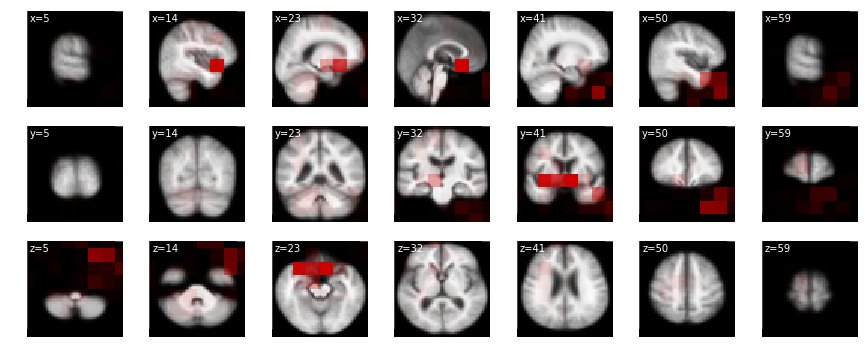

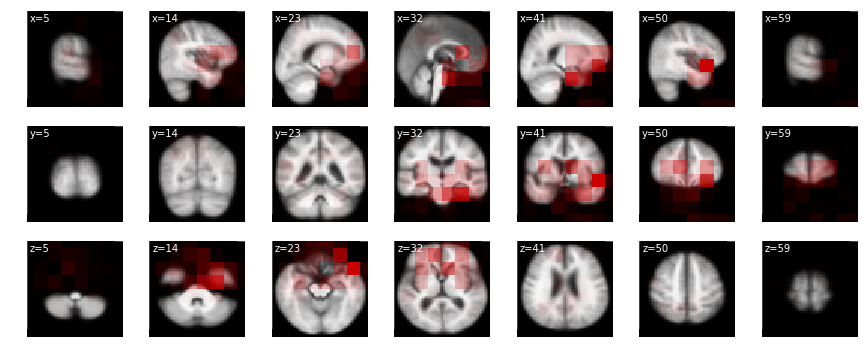

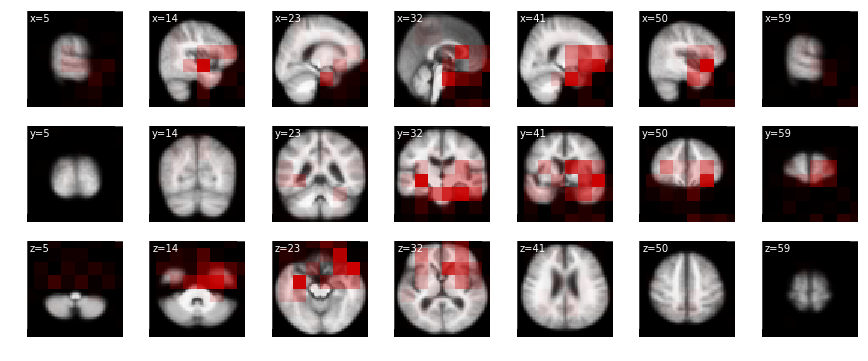

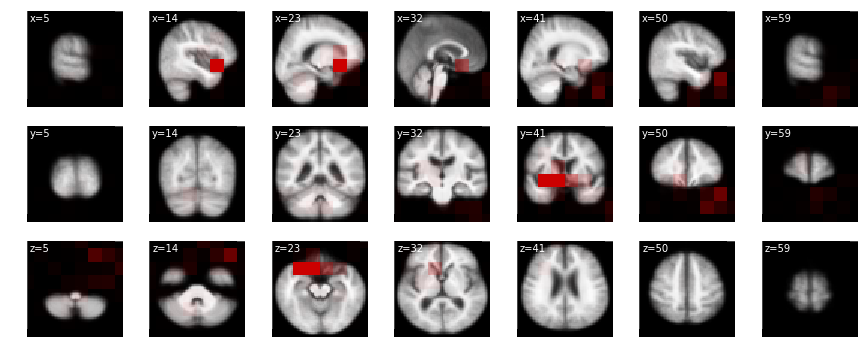

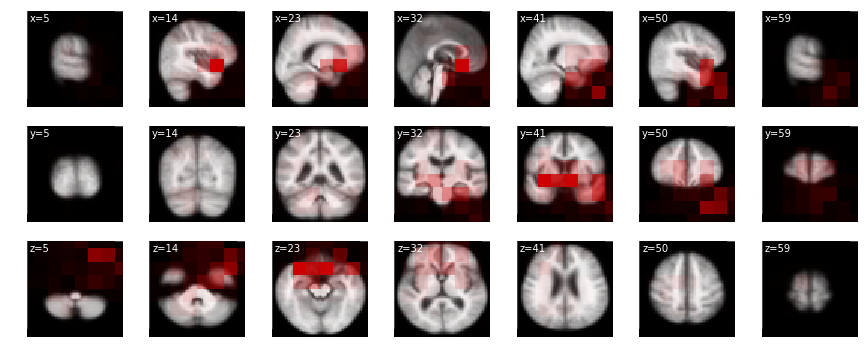

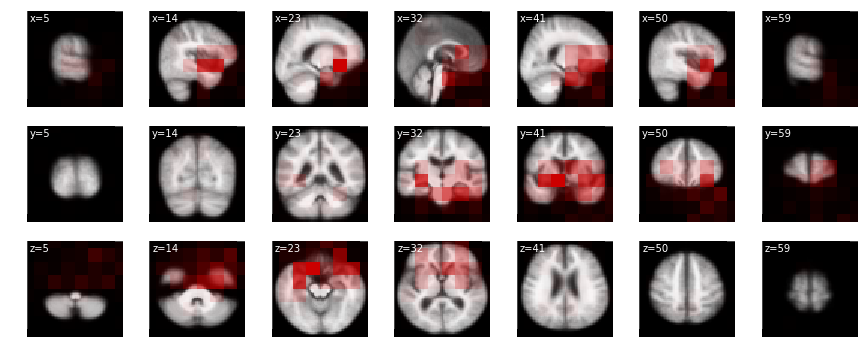

In [0]:
# now we plot the averaged maps, for each category!
# probably want to do some quantitative results with the vmin, vmax, overlay min/max
vmin_AD_correct, vmax_AD_correct, overlay_vmin_AD_correct, overlay_vmax_AD_correct = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_AD_correct[0], 
                  overlay_vmax=np.percentile(map_AD_correct, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_AD_wrong, vmax_AD_wrong, overlay_vmin_AD_wrong, overlay_vmax_AD_wrong = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_AD_wrong[0], 
                  overlay_vmax=np.percentile(map_AD_wrong, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_NC_correct, vmax_NC_correct, overlay_vmin_NC_correct, overlay_vmax_NC_correct = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_NC_correct[0], 
                  overlay_vmax=np.percentile(map_NC_correct, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_NC_wrong, vmax_NC_wrong, overlay_vmin_NC_wrong, overlay_vmax_NC_wrong = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_NC_wrong[0], 
                  overlay_vmax=np.percentile(map_NC_wrong, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_AD, vmax_AD, overlay_vmin_AD, overlay_vmax_AD = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_AD[0], 
                  overlay_vmax=np.percentile(map_AD, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_NC, vmax_NC, overlay_vmin_NC, overlay_vmax_NC = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_NC[0], 
                  overlay_vmax=np.percentile(map_NC, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

In [0]:
# get relevance areas across each category
from operator import itemgetter

res_AD_correct = dict(sorted(dict_AD_correct.items(), key = itemgetter(1), reverse = True)[:5])
res_AD_wrong = dict(sorted(dict_AD_wrong.items(), key = itemgetter(1), reverse = True)[:5])
res_NC_correct = dict(sorted(dict_NC_correct.items(), key = itemgetter(1), reverse = True)[:5])
res_NC_wrong = dict(sorted(dict_NC_wrong.items(), key = itemgetter(1), reverse = True)[:5])
res_AD = dict(sorted(dict_AD.items(), key = itemgetter(1), reverse = True)[:5])
res_NC = dict(sorted(dict_NC.items(), key = itemgetter(1), reverse = True)[:5])

print(res_AD_correct)
print(res_AD_wrong)
print(res_NC_correct)
print(res_NC_wrong)
print(res_AD)
print(res_NC)

{'Temporal_Inf': 6.339694923951791, 'Frontal_Inf_Orb': 4.984722625362185, 'Temporal_Mid': 4.126266996805976, 'Fusiform': 3.836837796230538, 'Temporal_Pole_Sup': 3.648646631779785}
{'Temporal_Mid': 2.6345341303224576, 'Temporal_Sup': 2.11485828796898, 'Frontal_Mid': 1.5529853260668862, 'SupraMarginal': 1.0059933454416932, 'Temporal_Inf': 0.978036842779977}
{'Temporal_Mid': 18.291949402796405, 'Temporal_Sup': 12.923258302944634, 'Lingual': 6.0674816787794335, 'Temporal_Inf': 5.577222240589474, 'Precuneus': 4.494118285330307}
{'Temporal_Inf': 1.2647338780301942, 'Frontal_Inf_Orb': 1.2202151050277763, 'Temporal_Mid': 0.9671993943533268, 'Temporal_Pole_Sup': 0.9461578918006455, 'Fusiform': 0.75897632976355}
{'Temporal_Inf': 7.317731766731768, 'Temporal_Mid': 6.760801127128433, 'Frontal_Inf_Orb': 4.984722625362185, 'Fusiform': 4.456785170790078, 'Temporal_Pole_Sup': 3.648646631779785}
{'Temporal_Mid': 19.25914879714973, 'Temporal_Sup': 12.959042027988497, 'Temporal_Inf': 6.841956118619668, '

# Brain area occlusion

In [0]:
# shape: (1, 64, 64, 64)
# relevance maps; to be averaged after summing
map_AD_correct = np.zeros((1, 64, 64, 64))
map_AD_wrong = np.zeros((1, 64, 64, 64))
map_NC_correct = np.zeros((1, 64, 64, 64))
map_NC_wrong = np.zeros((1, 64, 64, 64))
map_AD = np.zeros((1, 64, 64, 64))
map_NC = np.zeros((1, 64, 64, 64))

# counts... to keep track and average later
count_AD_correct = 0
count_AD_wrong = 0
count_NC_correct = 0
count_NC_wrong = 0
count_AD = 0
count_NC = 0

# average of test images
img_AD_correct = np.zeros((64, 64, 64))
img_AD_wrong = np.zeros((64, 64, 64))
img_NC_correct = np.zeros((64, 64, 64))
img_NC_wrong = np.zeros((64, 64, 64))
img_AD = np.zeros((64, 64, 64))
img_NC = np.zeros((64, 64, 64))
img_global = np.zeros((64, 64, 64)) # average of entire dataset

# dict of top brain areas; to be summed
dict_AD_correct = {}
dict_AD_wrong = {}
dict_NC_correct = {}
dict_NC_wrong = {}
dict_AD = {}
dict_NC = {}

for i in range(251):
  #if i % 20 == 0:
  print("i: ", i)
  label = test_label[i]
  relevance_map_backprop, pred_label, _ = interpretation.area_occlusion(net, test_data[i], area_masks, cuda=False, verbose=True)
  case = -1
  if label == 1 and pred_label == 1:
    case = 1
    count_AD_correct += 1
    img_AD_correct += test_data[i][0]
    map_AD_correct += relevance_map_backprop
  elif label == 1 and pred_label == 0:
    case = 2
    count_AD_wrong += 1
    img_AD_wrong += test_data[i][0]
    map_AD_wrong += relevance_map_backprop
  elif label == 0 and pred_label == 0:
    case = 3
    count_NC_correct += 1
    img_NC_correct += test_data[i][0]
    map_NC_correct += relevance_map_backprop
  elif label == 0 and pred_label == 1:
    case = 4
    count_NC_wrong += 1
    img_NC_wrong += test_data[i][0]
    map_NC_wrong += relevance_map_backprop
  else:
    print("entered invalid case with (label, pred_label) = ", label, pred_label)
  
  areas_top_ten = get_relevance_per_area(relevance_map_backprop)[:10]
  dict_example = None
  if case == 1:
    dict_example = dict_AD_correct
  elif case == 2:
    dict_example = dict_AD_wrong
  elif case == 3:
    dict_example = dict_NC_correct
  elif case == 4:
    dict_example = dict_NC_wrong
  else: 
    print("invalid case ", case)
  for (area, pct) in areas_top_ten:
    if area in dict_example:
      dict_example[area] += pct
    else:
      dict_example[area] = pct



i:  0
Image was classified as 0 with probability 0.9981356577482074
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  1


/Users/elissali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


Image was classified as 0 with probability 0.994742373470217
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  2
Image was classified as 0 with probability 0.9964518633205444
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  3
Image was classified as 1 with probability 0.9962234497070312
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  4
Image was classified as 1 with probability 0.9981884360313416
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  5
Image was classified as 1 with probability 0.9979420304298401
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  6
Image was classified as 1 with probability 0.9976006150245667
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  7
Image was classified as 0 with probability 0.9968048497103155
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  8
Image was classified as 0 with probability 0.9969273102469742
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  9
Image was classified as 0 with probability 0.9940813048742712
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  10
Image was classified as 0 with probability 0.9978246157988906
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  11
Image was classified as 1 with probability 0.7497469186782837
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  12
Image was classified as 0 with probability 0.9982770358910784
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  13
Image was classified as 0 with probability 0.9982236202340573
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  14
Image was classified as 0 with probability 0.9982992646982893
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  15
Image was classified as 0 with probability 0.9982825133483857
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  16
Image was classified as 0 with probability 0.9983389928238466
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  17
Image was classified as 0 with probability 0.9983131458284333
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  18
Image was classified as 0 with probability 0.9981548797804862
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  19
Image was classified as 0 with probability 0.9982078031171113
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  20
Image was classified as 0 with probability 0.9982691329205409
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  21
Image was classified as 0 with probability 0.9982922748895362
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  22
Image was classified as 0 with probability 0.9982667560689151
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  23
Image was classified as 0 with probability 0.9977611280046403
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  24
Image was classified as 0 with probability 0.9969835437368602
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  25
Image was classified as 0 with probability 0.9969877826515585
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  26
Image was classified as 0 with probability 0.997987927403301
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  27
Image was classified as 0 with probability 0.9974395737517625
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  28
Image was classified as 0 with probability 0.9983124574646354
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  29
Image was classified as 0 with probability 0.9983231822261587
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  30
Image was classified as 0 with probability 0.9983243216993287
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  31
Image was classified as 0 with probability 0.9983396087773144
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  32
Image was classified as 0 with probability 0.9980514716589823
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  33
Image was classified as 0 with probability 0.9744765553623438
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  34
Image was classified as 1 with probability 0.9637480974197388
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  35
Image was classified as 1 with probability 0.9771571755409241
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  36
Image was classified as 1 with probability 0.9944087862968445
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  37
Image was classified as 1 with probability 0.9979801774024963
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  38
Image was classified as 1 with probability 0.9976087808609009
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  39
Image was classified as 1 with probability 0.9976000189781189
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  40
Image was classified as 0 with probability 0.9857940766960382
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  41
Image was classified as 0 with probability 0.937786053866148
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  42
Image was classified as 0 with probability 0.9918612763285637
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  43
Image was classified as 0 with probability 0.9872049344703555
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  44
Image was classified as 0 with probability 0.9980966681614518
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  45
Image was classified as 0 with probability 0.9983213740633801
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  46
Image was classified as 0 with probability 0.9982945543015376
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  47
Image was classified as 0 with probability 0.9982667082222179
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  48
Image was classified as 0 with probability 0.9982263350393623
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  49
Image was classified as 0 with probability 0.9983149018371478
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  50
Image was classified as 1 with probability 0.9661389589309692
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  51
Image was classified as 1 with probability 0.9874279499053955
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  52
Image was classified as 1 with probability 0.9938936829566956
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  53
Image was classified as 1 with probability 0.9978923201560974
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  54
Image was classified as 1 with probability 0.9982582926750183
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  55
Image was classified as 0 with probability 0.998322247993201
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  56
Image was classified as 0 with probability 0.9983369729015976
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  57
Image was classified as 0 with probability 0.9983212158549577
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  58
Image was classified as 0 with probability 0.9983108137967065
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  59
Image was classified as 0 with probability 0.9983234711689875
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  60
Image was classified as 1 with probability 0.9874244332313538
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  61
Image was classified as 0 with probability 0.9982924869982526
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  62
Image was classified as 0 with probability 0.9982413477264345
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  63
Image was classified as 0 with probability 0.9980058805085719
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  64
Image was classified as 0 with probability 0.9983561938861385
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  65
Image was classified as 0 with probability 0.998353835195303
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  66
Image was classified as 0 with probability 0.9983470379374921
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  67
Image was classified as 0 with probability 0.9983625794993713
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  68
Image was classified as 1 with probability 0.963746190071106
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  69
Image was classified as 1 with probability 0.9970036149024963
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  70
Image was classified as 0 with probability 0.9983321153558791
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  71
Image was classified as 0 with probability 0.9983430436113849
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  72
Image was classified as 0 with probability 0.9983278445433825
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  73
Image was classified as 0 with probability 0.998327759327367
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  74
Image was classified as 0 with probability 0.998307982692495
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  75
Image was classified as 0 with probability 0.9983269337099046
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  76
Image was classified as 0 with probability 0.9983181729912758
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  77
Image was classified as 0 with probability 0.9968153280206025
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  78
Image was classified as 0 with probability 0.9943070928566158
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  79
Image was classified as 0 with probability 0.8799530938267708
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  80
Image was classified as 0 with probability 0.9870804147794843
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  81
Image was classified as 0 with probability 0.9392878822982311
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  82
Image was classified as 1 with probability 0.9136309623718262
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  83
Image was classified as 0 with probability 0.5944467484951019
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  84
Image was classified as 1 with probability 0.9415837526321411
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  85
Image was classified as 0 with probability 0.6732941269874573
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  86
Image was classified as 0 with probability 0.972098870202899
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  87
Image was classified as 1 with probability 0.9972633123397827
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  88
Image was classified as 1 with probability 0.9955064058303833
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  89
Image was classified as 1 with probability 0.9972456693649292
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  90
Image was classified as 1 with probability 0.942322850227356
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  91
Image was classified as 1 with probability 0.8530322313308716
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  92
Image was classified as 1 with probability 0.9193318486213684
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  93
Image was classified as 1 with probability 0.9952604174613953
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  94
Image was classified as 0 with probability 0.9975904165767133
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  95
Image was classified as 0 with probability 0.9978199757169932
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  96
Image was classified as 0 with probability 0.9980427036061883
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  97
Image was classified as 0 with probability 0.9978982137981802
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  98
Image was classified as 0 with probability 0.9981510866200551
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  99
Image was classified as 0 with probability 0.9377982765436172
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  100
Image was classified as 1 with probability 0.9824804663658142
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  101
Image was classified as 1 with probability 0.997397780418396
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  102
Image was classified as 0 with probability 0.996724535478279
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  103
Image was classified as 0 with probability 0.9219841808080673
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  104
Image was classified as 0 with probability 0.9961543409153819
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  105
Image was classified as 0 with probability 0.9684260748326778
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  106
Image was classified as 0 with probability 0.9981878164689988
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  107
Image was classified as 1 with probability 0.9979968667030334
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  108
Image was classified as 1 with probability 0.9977957010269165
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  109
Image was classified as 0 with probability 0.9911138322204351
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  110
Image was classified as 0 with probability 0.9936549724079669
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  111
Image was classified as 0 with probability 0.9965518093667924
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  112
Image was classified as 0 with probability 0.9873885307461023
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  113
Image was classified as 0 with probability 0.9983038309728727
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  114
Image was classified as 0 with probability 0.9983087443979457
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  115
Image was classified as 0 with probability 0.9983022534288466
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  116
Image was classified as 0 with probability 0.9983147309394553
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  117
Image was classified as 0 with probability 0.9983319017337635
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  118
Image was classified as 0 with probability 0.993763240519911
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  119
Image was classified as 1 with probability 0.8423544764518738
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  120
Image was classified as 0 with probability 0.9981624861247838
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  121
Image was classified as 0 with probability 0.9981225667288527
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  122
Image was classified as 0 with probability 0.9982332822401077
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  123
Image was classified as 0 with probability 0.9981649750843644
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  124
Image was classified as 0 with probability 0.9982276835944504
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  125
Image was classified as 0 with probability 0.9983094794442877
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  126
Image was classified as 0 with probability 0.9982578449416906
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  127
Image was classified as 0 with probability 0.9982623297255486
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  128
Image was classified as 0 with probability 0.9981996739516035
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  129
Image was classified as 0 with probability 0.9983535091159865
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  130
Image was classified as 0 with probability 0.9981789268786088
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  131
Image was classified as 0 with probability 0.9981018571415916
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  132
Image was classified as 0 with probability 0.9983035598415881
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  133
Image was classified as 1 with probability 0.9659955501556396
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  134
Image was classified as 1 with probability 0.9970515966415405
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  135
Image was classified as 1 with probability 0.9959350824356079
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  136
Image was classified as 1 with probability 0.9974186420440674
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  137
Image was classified as 1 with probability 0.9975348711013794
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  138
Image was classified as 0 with probability 0.9970599382650107
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  139
Image was classified as 0 with probability 0.9975093309767544
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  140
Image was classified as 0 with probability 0.9946776563301682
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  141
Image was classified as 0 with probability 0.9977870064321905
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  142
Image was classified as 0 with probability 0.9972598415333778
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  143
Image was classified as 0 with probability 0.9969784803688526
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  144
Image was classified as 0 with probability 0.996998249553144
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  145
Image was classified as 0 with probability 0.9937837291508913
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  146
Image was classified as 0 with probability 0.9341768100857735
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  147
Image was classified as 1 with probability 0.8261781334877014
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  148
Image was classified as 1 with probability 0.9566100239753723
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  149
Image was classified as 1 with probability 0.9905520677566528
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  150
Image was classified as 1 with probability 0.9912934899330139
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  151
Image was classified as 0 with probability 0.9982469100505114
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  152
Image was classified as 0 with probability 0.9982633270556107
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  153
Image was classified as 0 with probability 0.9981605906505138
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  154
Image was classified as 0 with probability 0.9977846171241254
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  155
Image was classified as 0 with probability 0.9917410928755999
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  156
Image was classified as 1 with probability 0.9980061650276184
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  157
Image was classified as 1 with probability 0.9885369539260864
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  158
Image was classified as 1 with probability 0.8363773226737976
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  159
Image was classified as 0 with probability 0.5397608876228333
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  160
Image was classified as 0 with probability 0.960943691432476
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  161
Image was classified as 0 with probability 0.9974073010962456
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  162
Image was classified as 1 with probability 0.9976100921630859
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  163
Image was classified as 1 with probability 0.9977937936782837
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  164
Image was classified as 0 with probability 0.9974736755248159
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  165
Image was classified as 0 with probability 0.9969223544467241
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  166
Image was classified as 0 with probability 0.9977632018271834
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  167
Image was classified as 0 with probability 0.9983462176751345
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  168
Image was classified as 0 with probability 0.9983502924442291
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  169
Image was classified as 0 with probability 0.9983473242027685
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  170
Image was classified as 0 with probability 0.9983221993315965
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  171
Image was classified as 0 with probability 0.9983433835441247
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  172
Image was classified as 0 with probability 0.9983150911284611
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  173
Image was classified as 0 with probability 0.9983268023934215
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  174
Image was classified as 0 with probability 0.9980265928898007
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  175
Image was classified as 0 with probability 0.9912946540862322
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  176
Image was classified as 0 with probability 0.9975489396601915
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  177
Image was classified as 0 with probability 0.9771744720637798
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  178
Image was classified as 0 with probability 0.9982010213425383
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  179
Image was classified as 0 with probability 0.7205913662910461
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  180
Image was classified as 1 with probability 0.9592643976211548
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  181
Image was classified as 1 with probability 0.9940034747123718
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  182
Image was classified as 0 with probability 0.9675397090613842
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  183
Image was classified as 0 with probability 0.9979268237948418
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  184
Image was classified as 0 with probability 0.9978400245308876
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  185
Image was classified as 0 with probability 0.9980476184282452
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  186
Image was classified as 0 with probability 0.998250936740078
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  187
Image was classified as 0 with probability 0.9982730519259349
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  188
Image was classified as 0 with probability 0.9981784545816481
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  189
Image was classified as 0 with probability 0.9982813372043893
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  190
Image was classified as 0 with probability 0.984533129259944
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  191
Image was classified as 0 with probability 0.9973046300001442
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  192
Image was classified as 1 with probability 0.994805634021759
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  193
Image was classified as 1 with probability 0.9967323541641235
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  194
Image was classified as 0 with probability 0.9981520446017385
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  195
Image was classified as 0 with probability 0.9978160827886313
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  196
Image was classified as 0 with probability 0.9975998783484101
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  197
Image was classified as 0 with probability 0.9783066529780626
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  198
Image was classified as 0 with probability 0.9976219949312508
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  199
Image was classified as 0 with probability 0.9978674734011292
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  200
Image was classified as 0 with probability 0.996941678924486
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  201
Image was classified as 0 with probability 0.9915730999782681
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  202
Image was classified as 0 with probability 0.5556524097919464
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  203
Image was classified as 0 with probability 0.9983091363683343
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  204
Image was classified as 0 with probability 0.9982907247031108
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  205
Image was classified as 0 with probability 0.9983017976628616
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  206
Image was classified as 0 with probability 0.998294853954576
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  207
Image was classified as 1 with probability 0.99073725938797
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  208
Image was classified as 0 with probability 0.7160139083862305
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  209
Image was classified as 0 with probability 0.9974350554402918
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  210
Image was classified as 1 with probability 0.9952184557914734
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  211
Image was classified as 0 with probability 0.9971787719987333
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  212
Image was classified as 0 with probability 0.9982439902378246
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  213
Image was classified as 1 with probability 0.9967156648635864
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  214
Image was classified as 1 with probability 0.9966604709625244
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  215
Image was classified as 1 with probability 0.9971876740455627
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  216
Image was classified as 1 with probability 0.9979119896888733
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  217
Image was classified as 1 with probability 0.989250898361206
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  218
Image was classified as 1 with probability 0.9963908791542053
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  219
Image was classified as 1 with probability 0.9973389506340027
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  220
Image was classified as 1 with probability 0.9977214932441711
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  221
Image was classified as 0 with probability 0.9983045931439847
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  222
Image was classified as 0 with probability 0.998024944216013
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  223
Image was classified as 1 with probability 0.9975302815437317
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  224
Image was classified as 0 with probability 0.7481370866298676
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  225
Image was classified as 0 with probability 0.9981890193885192
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  226
Image was classified as 0 with probability 0.9982420089654624
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  227
Image was classified as 0 with probability 0.998159013222903
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  228
Image was classified as 0 with probability 0.9982163609238341
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  229
Image was classified as 0 with probability 0.9982263384154066
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  230
Image was classified as 0 with probability 0.9982259118696675
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  231
Image was classified as 0 with probability 0.9961970616132021
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  232
Image was classified as 0 with probability 0.996517060790211
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  233
Image was classified as 0 with probability 0.9971293713897467
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  234
Image was classified as 0 with probability 0.9959113611839712
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  235
Image was classified as 0 with probability 0.9956869301386178
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  236
Image was classified as 1 with probability 0.996440589427948
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  237
Image was classified as 1 with probability 0.997021496295929
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  238
Image was classified as 0 with probability 0.997101011686027
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  239
Image was classified as 1 with probability 0.9528672695159912
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  240
Image was classified as 0 with probability 0.9934696103446186
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  241
Image was classified as 1 with probability 0.9969075322151184
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  242
Image was classified as 1 with probability 0.9973228573799133
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  243
Image was classified as 0 with probability 0.9971105041913688
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  244
Image was classified as 0 with probability 0.9976209576707333
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  245
Image was classified as 0 with probability 0.9774868078529835
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  246
Image was classified as 0 with probability 0.997709522023797
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  247
Image was classified as 0 with probability 0.9982631070306525
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  248
Image was classified as 1 with probability 0.7338491082191467
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  249
Image was classified as 1 with probability 0.9923582673072815
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)
i:  250
Image was classified as 1 with probability 0.9928820133209229
image tensor:  torch.Size([1, 64, 64, 64])
relevance map:  torch.Size([64, 64, 64])



(116,)


In [0]:
# some post-processing
map_AD = map_AD_correct + map_AD_wrong
map_NC = map_NC_correct + map_NC_wrong
count_AD = count_AD_correct + count_AD_wrong
count_NC = count_NC_correct + count_NC_wrong
img_AD = img_AD_correct + img_AD_wrong 
img_NC = img_NC_correct + img_NC_wrong
img_global = img_AD + img_NC

dict_AD = data.merge_dicts(dict_AD_correct, dict_AD_wrong)
dict_NC = data.merge_dicts(dict_NC_correct, dict_NC_wrong)

In [0]:
print(count_AD_correct, count_AD_wrong, count_NC_correct, count_NC_wrong)

57 32 149 13


In [0]:
# we need to average the maps across the number of examples that were summed up
map_AD_correct /= count_AD_correct
map_AD_wrong /= count_AD_wrong
map_NC_correct /= count_NC_correct
map_NC_wrong /= count_NC_wrong
map_AD /= count_AD
map_NC /= count_NC

# also average the images
img_AD_correct /= count_AD_correct
img_AD_wrong /= count_AD_wrong
img_NC_correct /= count_NC_correct
img_NC_wrong /= count_NC_wrong
img_AD /= count_AD
img_NC /= count_NC
img_global /= 251

-0.7620625321536576 1.9976536631661175 0.0 0.13817652798535532
-0.7620625321536576 1.9976536631661175 0.0 0.36783648519485723
-0.7620625321536576 1.9976536631661175 0.0 0.06637846500903442
-0.7620625321536576 1.9976536631661175 0.0 0.6290863385567298
-0.7620625321536576 1.9976536631661175 0.0 0.13397811187347503
-0.7620625321536576 1.9976536631661175 0.0 0.06296376500603525


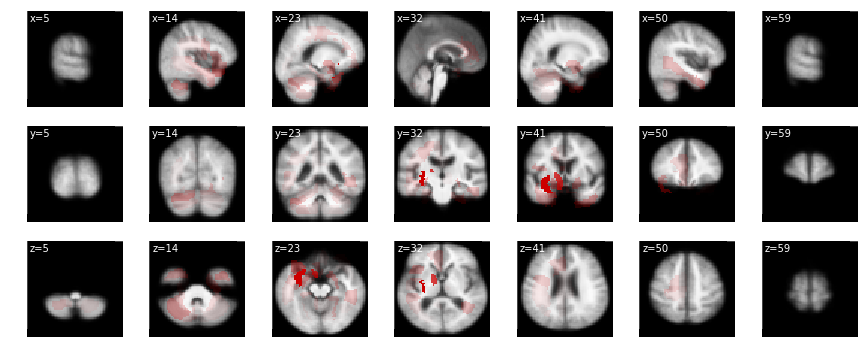

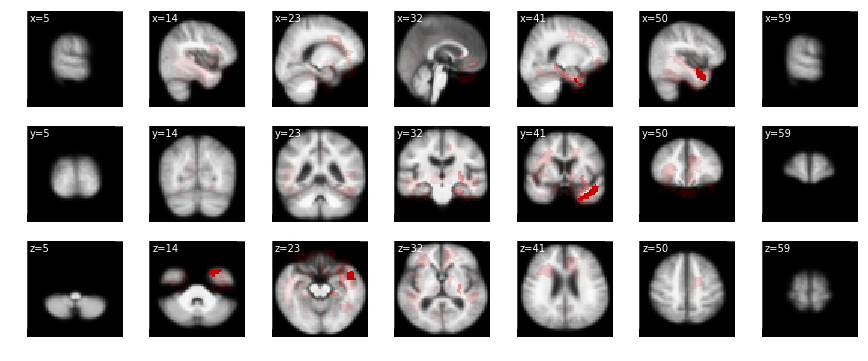

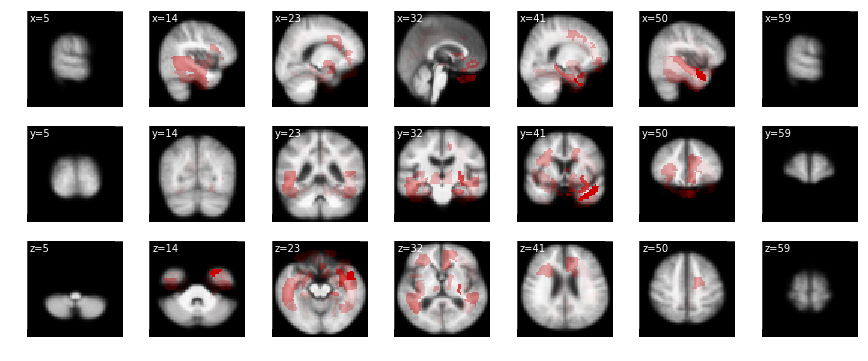

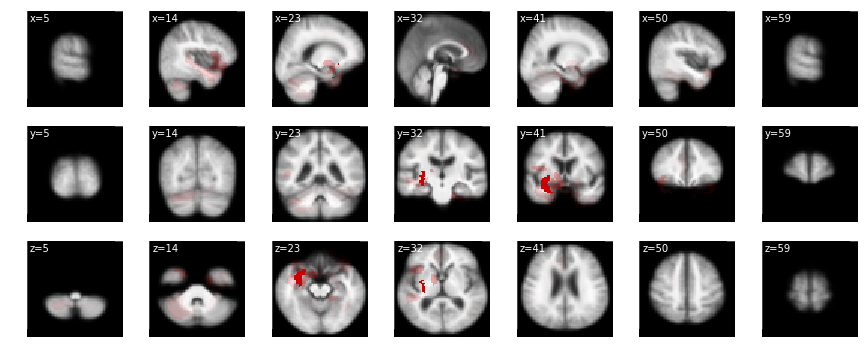

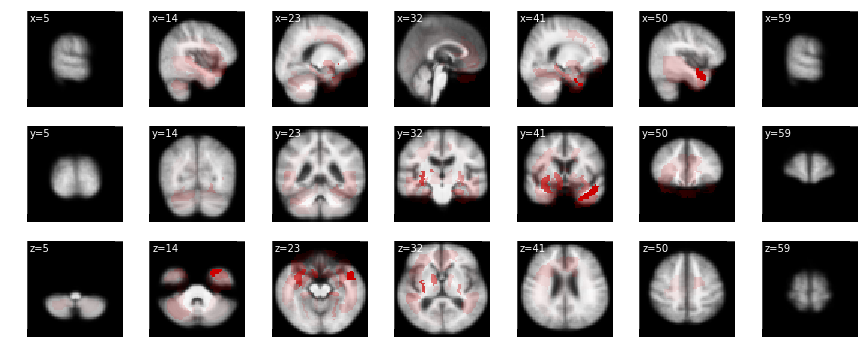

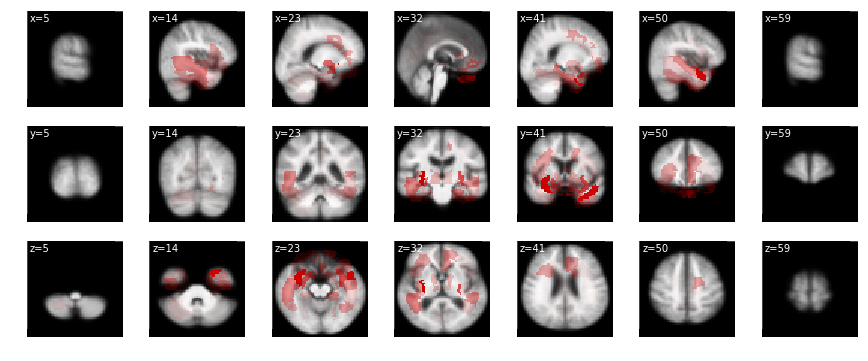

In [0]:
# now we plot the averaged maps, for each category!
# probably want to do some quantitative results with the vmin, vmax, overlay min/max
vmin_AD_correct, vmax_AD_correct, overlay_vmin_AD_correct, overlay_vmax_AD_correct = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_AD_correct[0], 
                  overlay_vmax=np.percentile(map_AD_correct, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_AD_wrong, vmax_AD_wrong, overlay_vmin_AD_wrong, overlay_vmax_AD_wrong = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_AD_wrong[0], 
                  overlay_vmax=np.percentile(map_AD_wrong, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_NC_correct, vmax_NC_correct, overlay_vmin_NC_correct, overlay_vmax_NC_correct = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_NC_correct[0], 
                  overlay_vmax=np.percentile(map_NC_correct, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_NC_wrong, vmax_NC_wrong, overlay_vmin_NC_wrong, overlay_vmax_NC_wrong = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_NC_wrong[0], 
                  overlay_vmax=np.percentile(map_NC_wrong, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_AD, vmax_AD, overlay_vmin_AD, overlay_vmax_AD = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_AD[0], 
                  overlay_vmax=np.percentile(map_AD, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

vmin_NC, vmax_NC, overlay_vmin_NC, overlay_vmax_NC = vis_utils.plot_slices(img_global, num_slices = 7, overlay=map_NC[0], 
                  overlay_vmax=np.percentile(map_NC, 99.9), 
                  overlay_cmap=vis_utils.alpha_to_red_cmap)

In [0]:
# get relevance areas across each category
from operator import itemgetter

res_AD_correct = dict(sorted(dict_AD_correct.items(), key = itemgetter(1), reverse = True)[:5])
res_AD_wrong = dict(sorted(dict_AD_wrong.items(), key = itemgetter(1), reverse = True)[:5])
res_NC_correct = dict(sorted(dict_NC_correct.items(), key = itemgetter(1), reverse = True)[:5])
res_NC_wrong = dict(sorted(dict_NC_wrong.items(), key = itemgetter(1), reverse = True)[:5])
res_AD = dict(sorted(dict_AD.items(), key = itemgetter(1), reverse = True)[:5])
res_NC = dict(sorted(dict_NC.items(), key = itemgetter(1), reverse = True)[:5])

print(res_AD_correct)
print(res_AD_wrong)
print(res_NC_correct)
print(res_NC_wrong)
print(res_AD)
print(res_NC)

{'Precentral': nan, 'Frontal_Sup': nan, 'Frontal_Sup_Orb': nan, 'Frontal_Mid': nan, 'Frontal_Mid_Orb': nan}
{'Precentral': nan, 'Frontal_Sup': nan, 'Frontal_Sup_Orb': nan, 'Frontal_Mid': nan, 'Frontal_Mid_Orb': nan}
{'Precentral': nan, 'Frontal_Sup': nan, 'Frontal_Sup_Orb': nan, 'Frontal_Mid': nan, 'Frontal_Mid_Orb': nan}
{'Precentral': nan, 'Frontal_Sup': nan, 'Frontal_Sup_Orb': nan, 'Frontal_Mid': nan, 'Frontal_Mid_Orb': nan}
{'Precentral': nan, 'Frontal_Sup': nan, 'Frontal_Sup_Orb': nan, 'Frontal_Mid': nan, 'Frontal_Mid_Orb': nan}
{'Precentral': nan, 'Frontal_Sup': nan, 'Frontal_Sup_Orb': nan, 'Frontal_Mid': nan, 'Frontal_Mid_Orb': nan}
